Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цель проекта

Состоит в разработке решения, которое предоставит персонализированные предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Ход исследования:

1) Подготовка данных - загрузка и анализ общей информации из предоставленных датасетов.

2) Предобработка данных - выявление пропущенных значений и дубликатов, переименование столбцов (приведение к нижнему регистру) и поиск аномальных значений.

3) Исследовательский анализ данных - изучение распределений количественных и категориальных признаков в датасетах.
4) Найти зависимости между данными. 

5) Обучение моделей машинного обучения - тестирование различных моделей для выбора наиболее эффективной (с максимальной метрикой ROC_AUC).

6) Оценка важности входных признаков.

7) Анализ сегмента покупателей - разработка рекомендаций для повышения покупательской активности в этом сегменте.

Общий вывод: 

Рекомендация наилучшей модели машинного обучения для прогнозирования покупательской способности и предложения по увеличению покупательской активности среди выбранных клиентов. 

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik import resources
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, 
                                     GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder, 
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)

from sklearn.metrics import (accuracy_score, 
                             recall_score,
                             precision_score, 
                             roc_auc_score,
                            classification_report)

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer 
import shap
import plotly.express as px
import statsmodels.api as sm
from sklearn.dummy import DummyClassifier

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head(3)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5

In [5]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [6]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head(3)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0

In [7]:
market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [8]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head(3)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10

In [9]:
market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [10]:
money = pd.read_csv('/datasets/money.csv',  sep = ';', decimal = ',')
money.head(3)

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13

In [11]:
money.columns

Index(['id', 'Прибыль'], dtype='object')

## Предобработка данных

In [12]:
market_file.head(3)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [14]:
duplicates = market_file[market_file.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


Empty DataFrame
Columns: [id, Покупательская активность, Тип сервиса, Разрешить сообщать, Маркет_актив_6_мес, Маркет_актив_тек_мес, Длительность, Акционные_покупки, Популярная_категория, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит]
Index: []

In [15]:
market_file.isnull().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [16]:
market_file = market_file.drop_duplicates()

In [17]:
market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [18]:
replacement = {
    'стандартт': 'стандарт'
}

market_file['Тип сервиса'] = market_file['Тип сервиса'].replace(replacement)
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [19]:
market_file['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [20]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [21]:
market_file = market_file.rename(columns={ 
                'Покупательская активность' : 'покупательская_активность', 
                'Тип сервиса' : 'тип_сервиса', 
                'Разрешить сообщать' : 'разрешить_сообщать',
                'Маркет_актив_6_мес' : 'маркет_актив_6_мес',
                'Маркет_актив_тек_мес' : 'маркет_актив_тек_мес', 
                'Длительность' : 'длительность',
                'Акционные_покупки' : 'акционные_покупки',
                'Популярная_категория' : 'популярная_категория',
                'Средний_просмотр_категорий_за_визит' : 'средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал' : 'неоплаченные_продукты_штук_квартал',
                'Ошибка_сервиса' : 'ошибка_сервиса',
                'Страниц_за_визит' : 'страниц_за_визит'})

In [22]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [23]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [24]:
duplicates = market_money[market_money.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


Empty DataFrame
Columns: [id, Период, Выручка]
Index: []

In [25]:
market_money.isnull().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [26]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [27]:
count = (market_money['Период'] == 'препредыдущий_месяц').sum()
count

1300

In [28]:
count = (market_money['Период'] == 'текущий_месяц').sum()
count

1300

In [29]:
market_money = market_money.rename(columns={ 
                'Период' : 'период', 
                'Выручка' : 'выручка'})

In [30]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [31]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [32]:
market_time.isnull().sum()

id        0
Период    0
минут     0
dtype: int64

In [33]:
duplicates = market_time[market_time.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


Empty DataFrame
Columns: [id, Период, минут]
Index: []

In [34]:
market_time = market_time.rename(columns={ 
                'Период' : 'период', 
                'Выручка' : 'выручка'})

In [35]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [36]:
replacement = {
    'предыдцщий_месяц': 'предыдущий_месяц'
}

market_time['период'] = market_time['период'].replace(replacement)
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [37]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [38]:
money.isnull().sum()

id         0
Прибыль    0
dtype: int64

In [39]:
duplicates = money[money.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


Empty DataFrame
Columns: [id, Прибыль]
Index: []

In [40]:
money = money.rename(columns={'Прибыль':'прибыль'})

In [41]:
money.columns

Index(['id', 'прибыль'], dtype='object')

- Название столбцов приведены к нижнему регистру.
- Не было найдено пропусков.
- Ошибку 'предыдцщий_месяц' была исправлена.
- Дубликатов я не нашел.

## Исследовательский анализ данных

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [42]:
market_file.describe().T

count           mean         std  \
id                                   1300.0  215997.500000  375.421985   
маркет_актив_6_мес                   1300.0       4.253769    1.014814   
маркет_актив_тек_мес                 1300.0       4.011538    0.696868   
длительность                         1300.0     601.898462  249.856289   
акционные_покупки                    1300.0       0.319808    0.249843   
средний_просмотр_категорий_за_визит  1300.0       3.270000    1.355350   
неоплаченные_продукты_штук_квартал   1300.0       2.840000    1.971451   
ошибка_сервиса                       1300.0       4.185385    1.955298   
страниц_за_визит                     1300.0       8.176923    3.978126   

                                          min        25%        50%  \
id                                   215348.0  215672.75  215997.50   
маркет_актив_6_мес                        0.9       3.70       4.20   
маркет_актив_тек_мес                      3.0       4.00       4.00   
длительность                            110.0     405.50     606.00   
акционные_покупки                         0.0       0.17       0.24   
средний_просмотр_категорий_за_визит       1.0       2.00       3.00   
неоплаченные_продукты_штук_квартал        0.0       1.00       3.00   
ошибка_сервиса                            0.0       3.00       4.00   
страниц_за_визит                          1.0       5.00       8.00   

                                           75%        max  
id                                   216322.25  216647.00  
маркет_актив_6_мес                        4.90       6.60  
маркет_актив_тек_мес                      4.00       5.00  
длительность                            806.00    1079.00  
акционные_покупки                         0.30       0.99  
средний_просмотр_категорий_за_визит       4.00       6.00  
неоплаченные_продукты_штук_квартал        4.00      10.00  
ошибка_сервиса                            6.00       9.00  
страниц_за_визит                         11.00      20.00

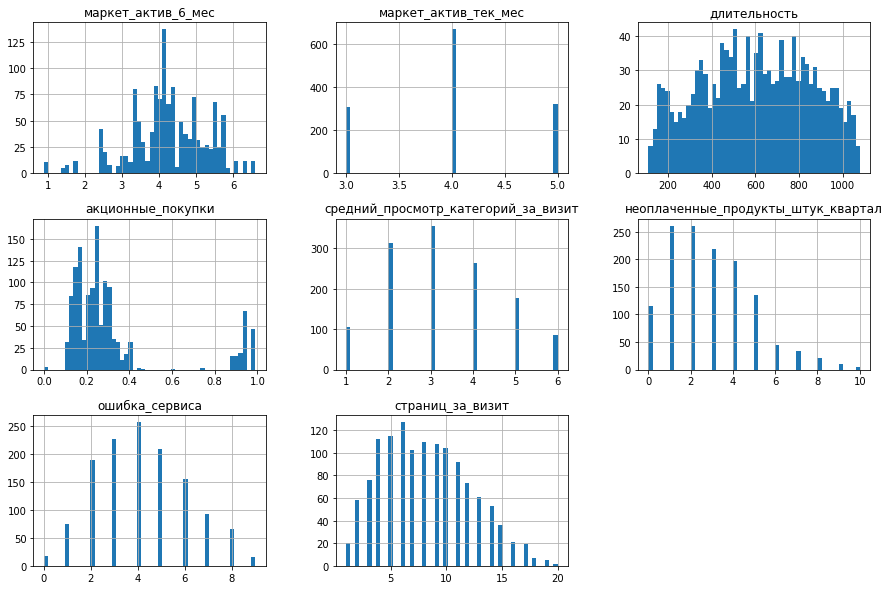

In [ ]:
market_file.drop(columns=['id']).hist(figsize = (15, 10), bins=50);

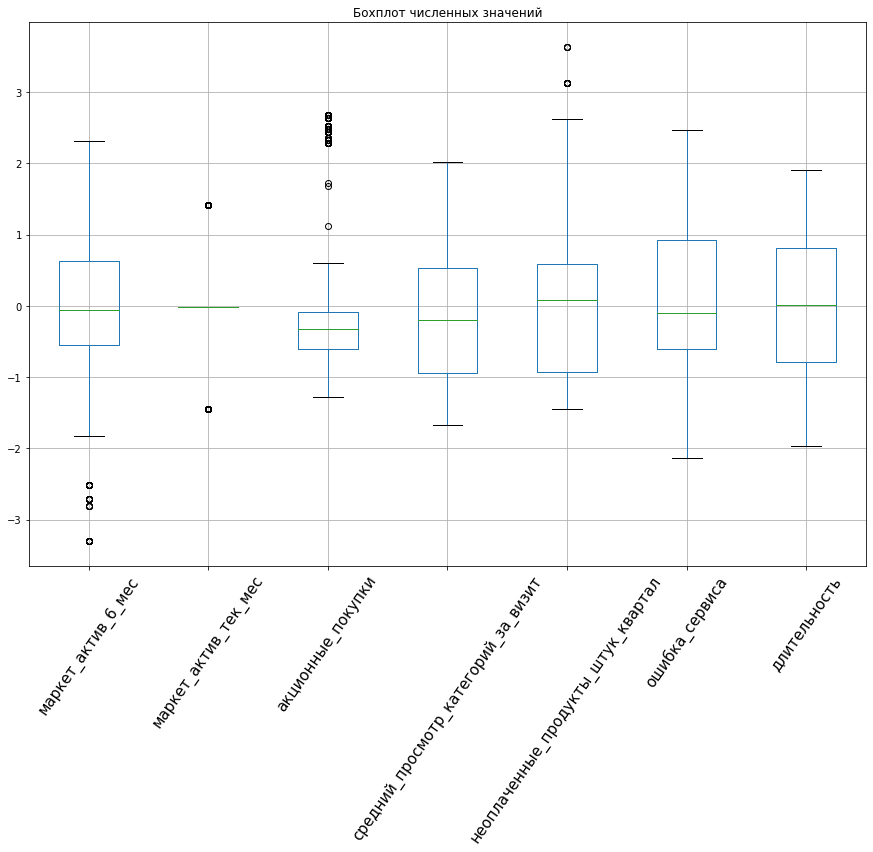

In [ ]:
scaler = StandardScaler()
box = scaler.fit_transform(market_file[['маркет_актив_6_мес','маркет_актив_тек_мес','акционные_покупки', 
             'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
             'ошибка_сервиса', 'длительность']])

normalized_df = pd.DataFrame(box, columns=['маркет_актив_6_мес','маркет_актив_тек_мес','акционные_покупки', 
             'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
             'ошибка_сервиса', 'длительность'])

plt.figure(figsize=(15, 10))

normalized_df.boxplot()

plt.xticks(rotation=55, fontsize=15)

plt.title('Бохплот численных значений')

plt.grid(True)

In [45]:
def graf_user(df, hue, x, word, x_label, y_label):
    sns.set_style('white')
    
    box = ['длительность']
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    if x in box:
        sns.histplot(df, bins=50, hue=hue, x=x, palette='Set1', ax=axes[0])
    else:
        sns.countplot(data=df, x=x, hue=hue, palette='Set1', ax=axes[0])

    axes[0].set_title(f'Покупательская активность в зависимости от {word}', fontsize=16, fontweight="normal", color='black')
    axes[0].set_xlabel(f'{x_label}', fontsize=16, fontweight="normal", color='black')
    axes[0].set_ylabel(f'{y_label}', fontsize=16, fontweight="normal", color='black')
    axes[0].grid(color='black', linewidth=1, alpha=0.3)
    
    sns.boxplot(data=df, x=x, ax=axes[1], palette='Set1')
    axes[1].set_title(f'Покупательская активность в зависимости от {word}', fontsize=16, fontweight="normal", color='black')
    axes[1].set_xlabel(f'{x_label}', fontsize=16, fontweight="normal", color='black')
    axes[1].set_ylabel(f'{y_label}', fontsize=16, fontweight="normal", color='black')
    axes[1].grid(color='black', linewidth=1, alpha=0.3)
    
    plt.tight_layout()
    plt.show();

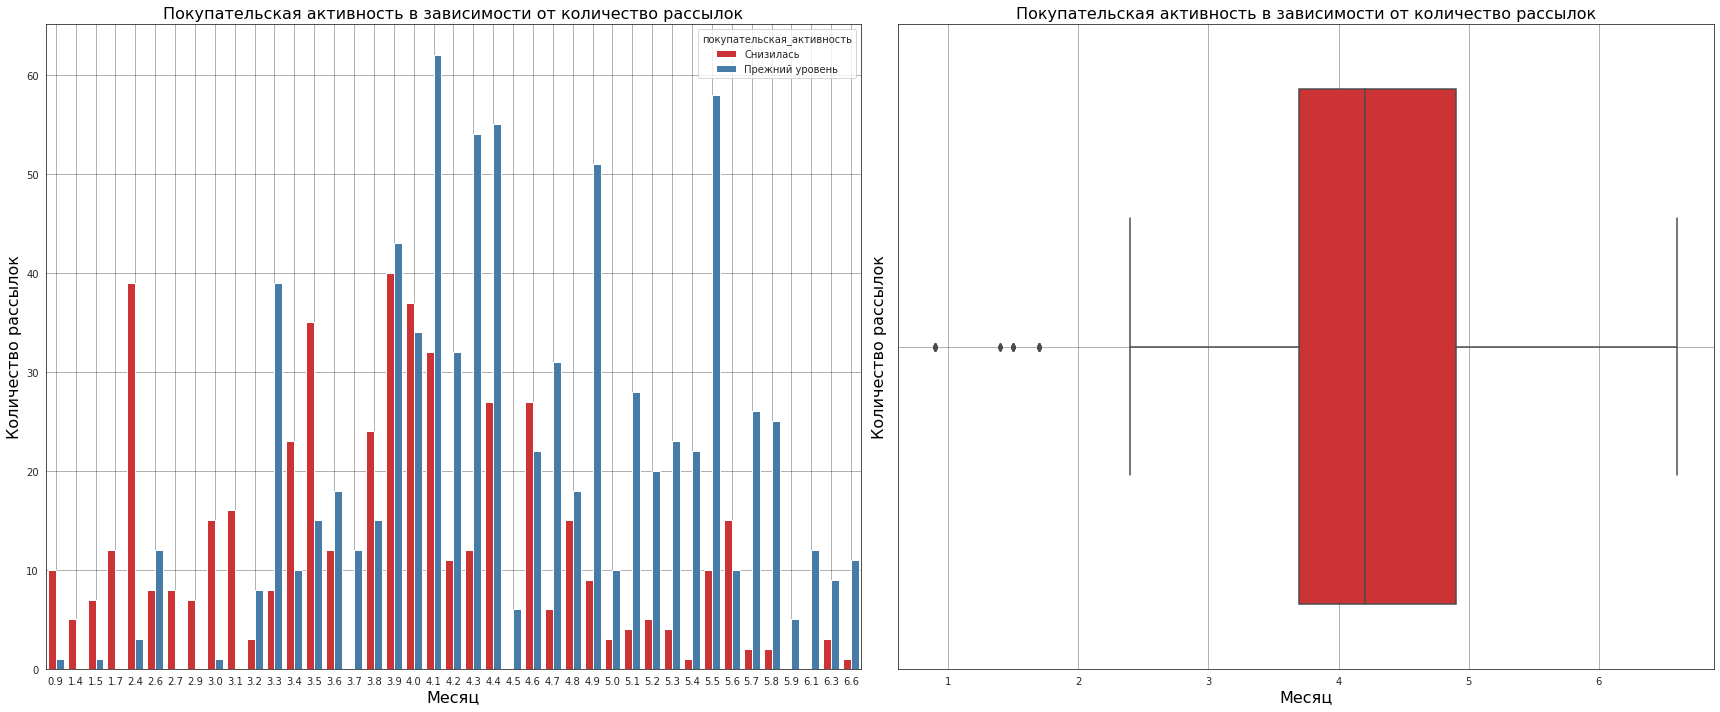

In [46]:
graf_user(df=market_file, hue='покупательская_активность', x='маркет_актив_6_мес', word='количество рассылок', x_label='Месяц', y_label='Количество рассылок')

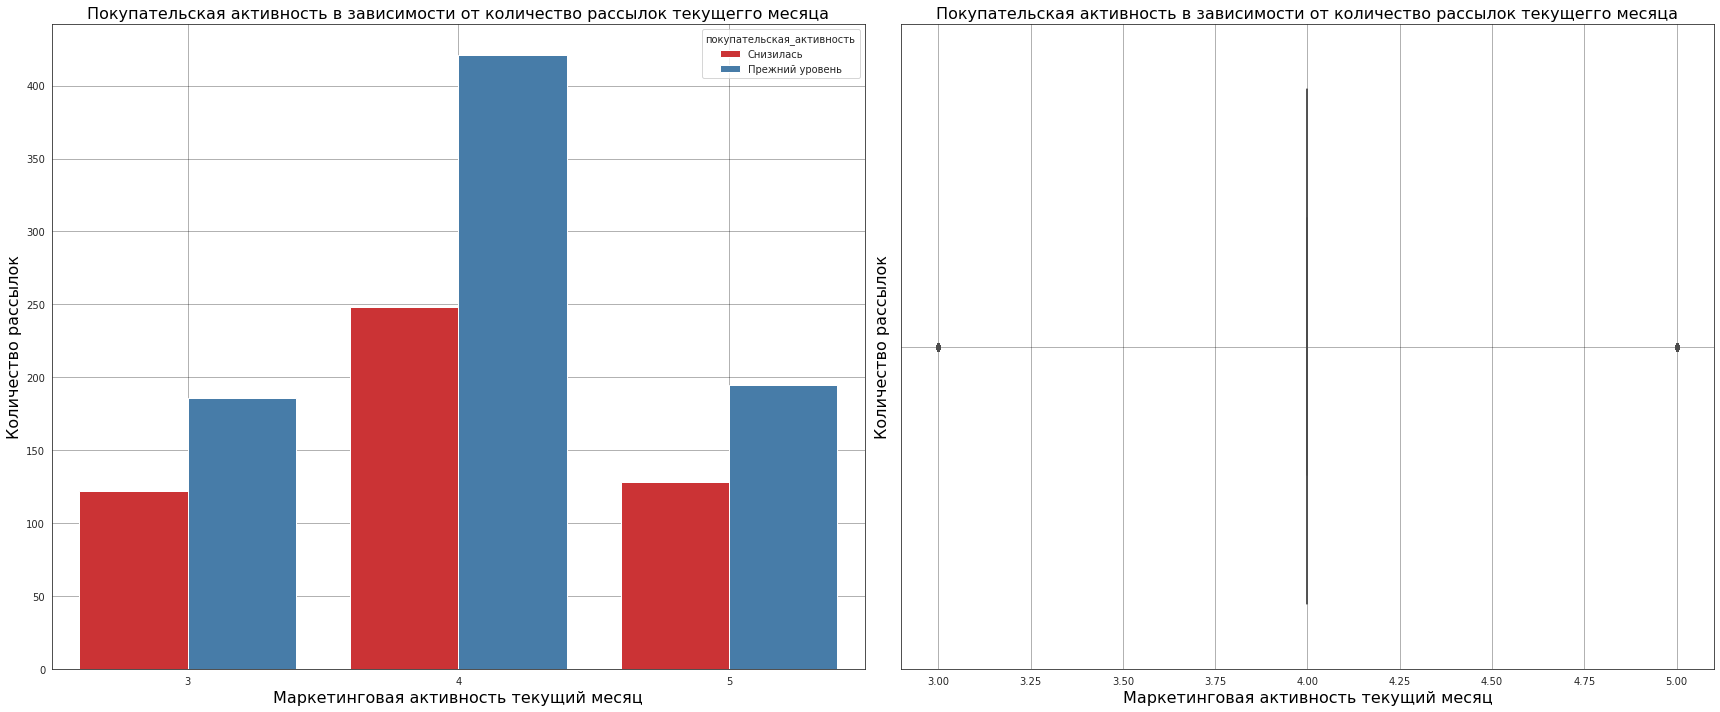

In [47]:
graf_user(df=market_file, hue='покупательская_активность', x='маркет_актив_тек_мес', word='количество рассылок текущегго месяца', x_label='Маркетинговая активность текущий месяц', y_label='Количество рассылок')

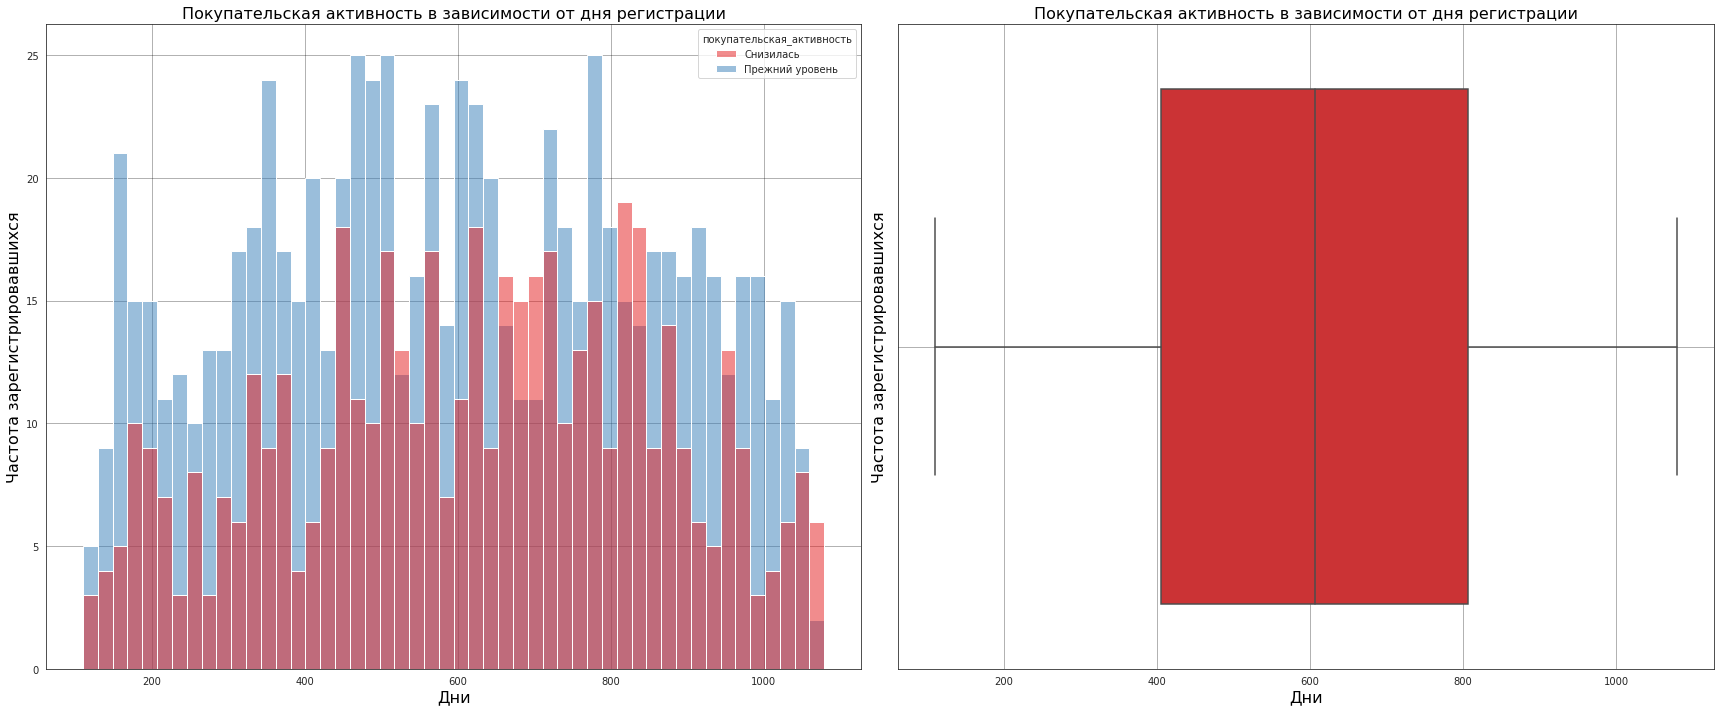

In [48]:
graf_user(df=market_file, hue='покупательская_активность', x='длительность', word='дня регистрации', x_label='Дни', y_label='Частота зарегистрировавшихся')

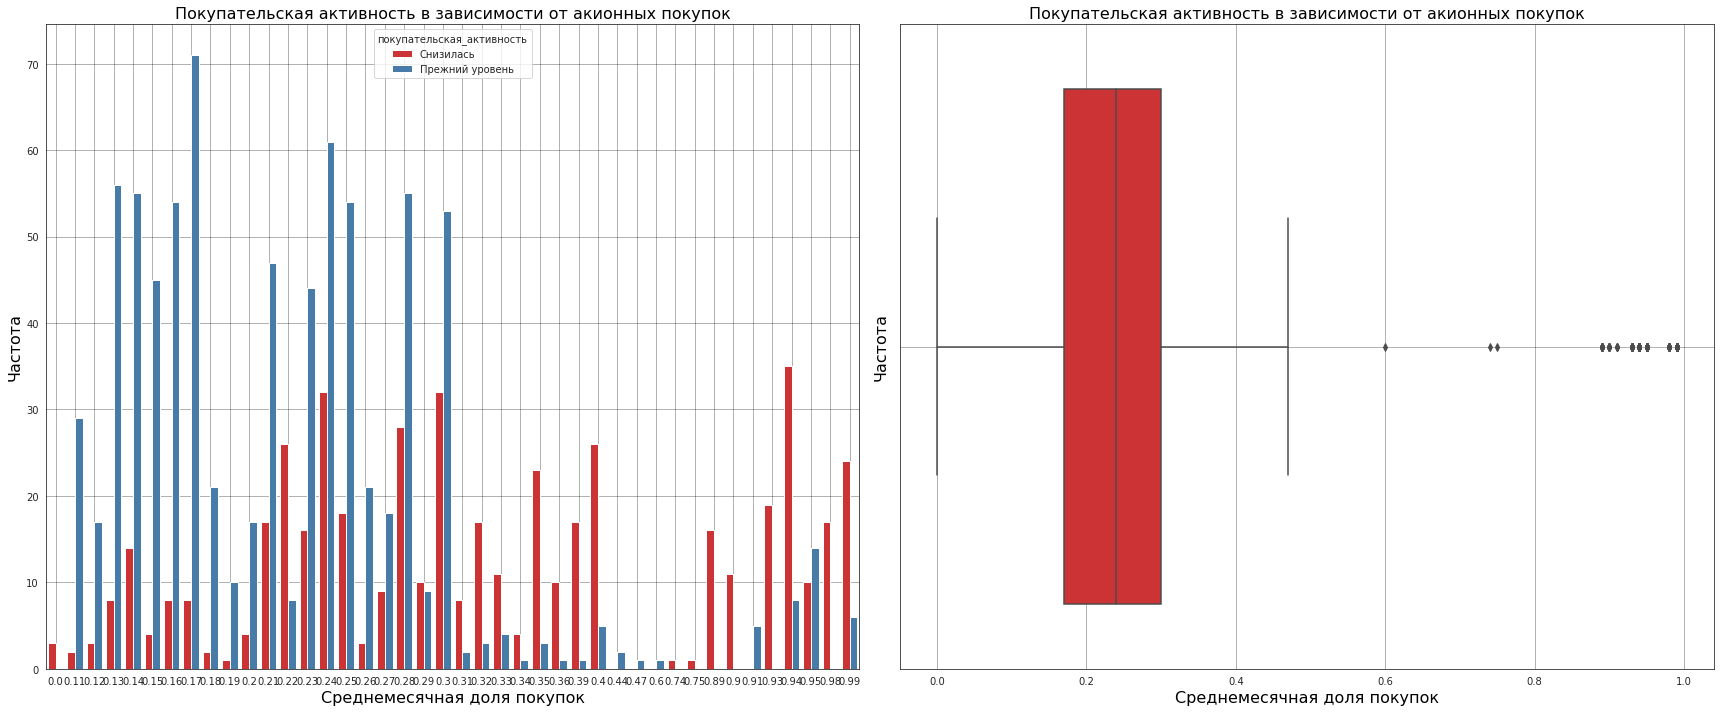

In [49]:
graf_user(df=market_file, hue='покупательская_активность', x='акционные_покупки', word='акионных покупок', x_label='Среднемесячная доля покупок', y_label='Частота')

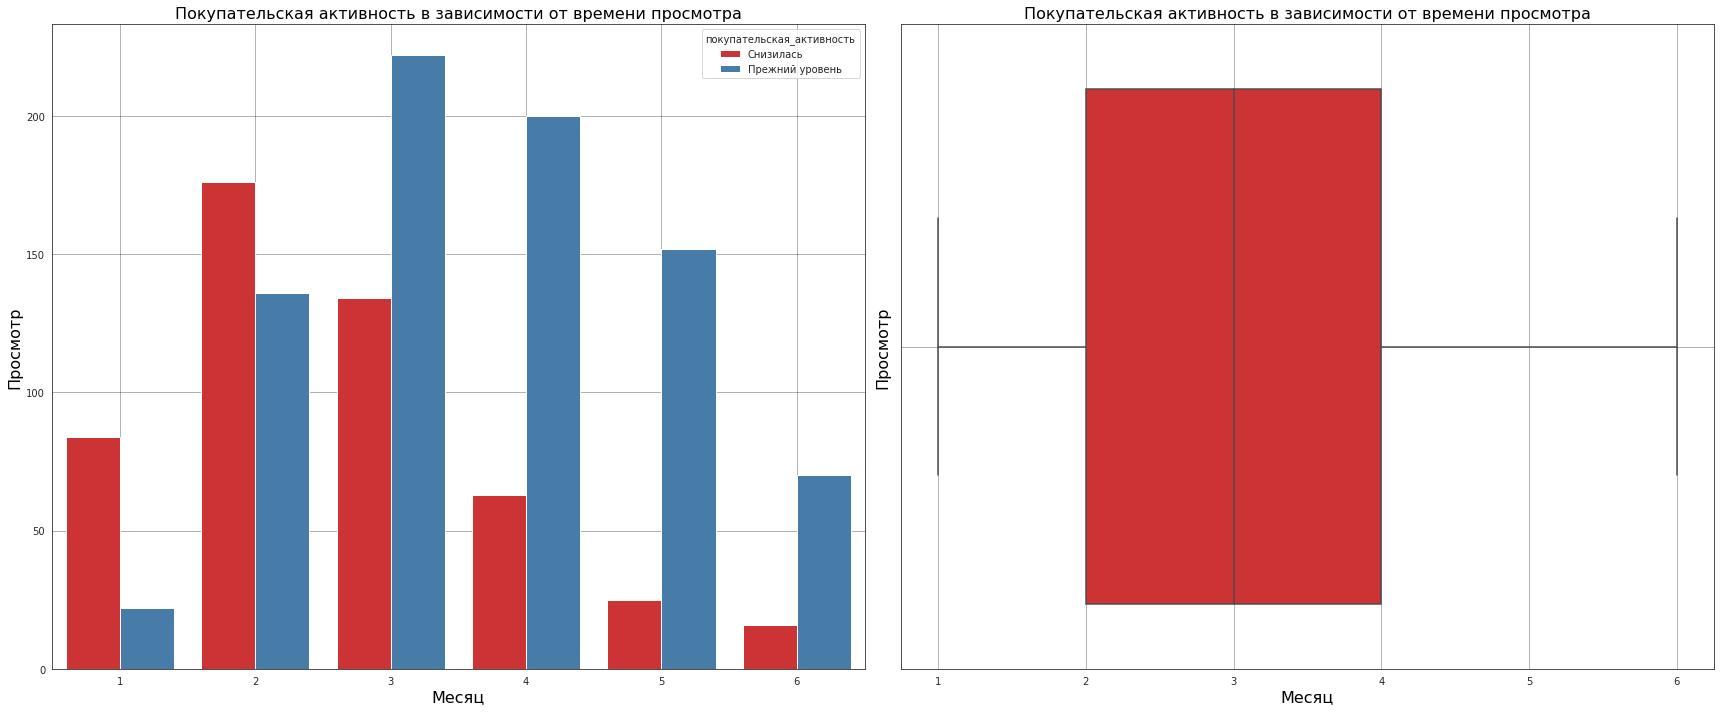

In [50]:
graf_user(df=market_file, hue='покупательская_активность', x='средний_просмотр_категорий_за_визит', word='времени просмотра', x_label='Месяц', y_label='Просмотр')

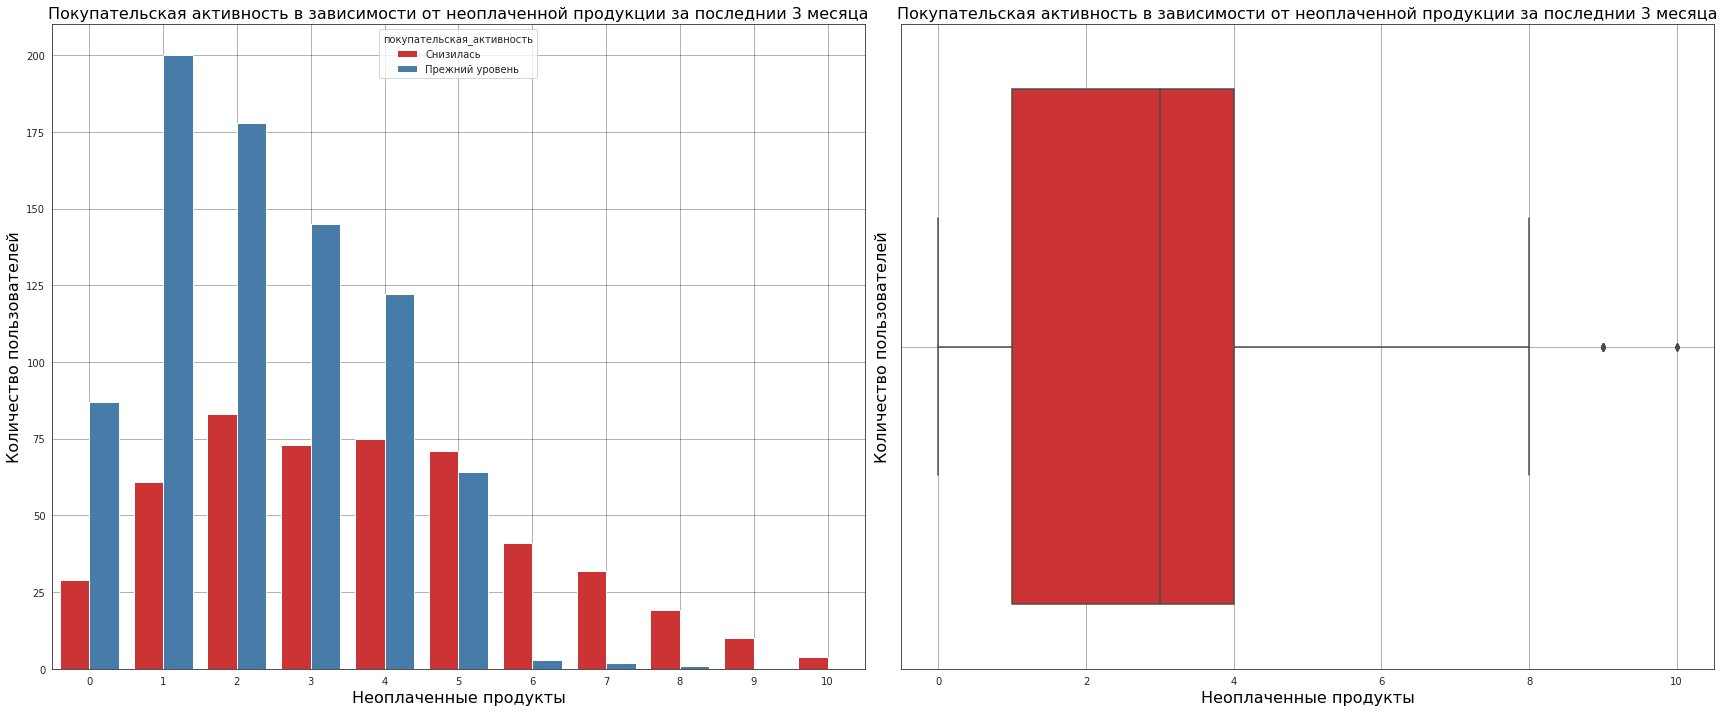

In [51]:
graf_user(df=market_file, hue='покупательская_активность', x='неоплаченные_продукты_штук_квартал', word='неоплаченной продукции за последнии 3 месяца', x_label='Неоплаченные продукты', y_label='Количество пользователей')

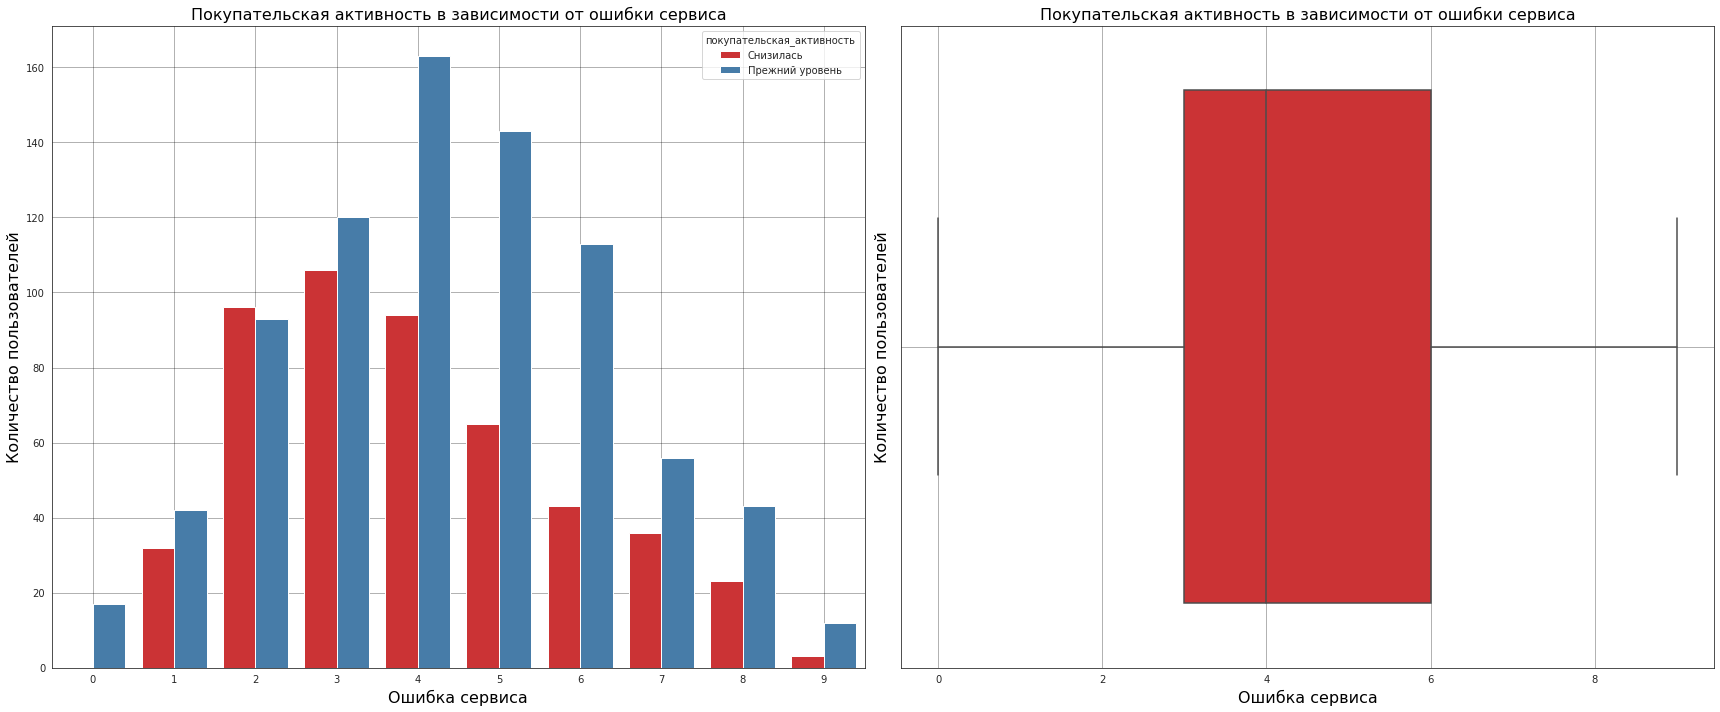

In [52]:
graf_user(df=market_file, hue='покупательская_активность', x='ошибка_сервиса', word='ошибки сервиса', x_label='Ошибка сервиса', y_label='Количество пользователей')

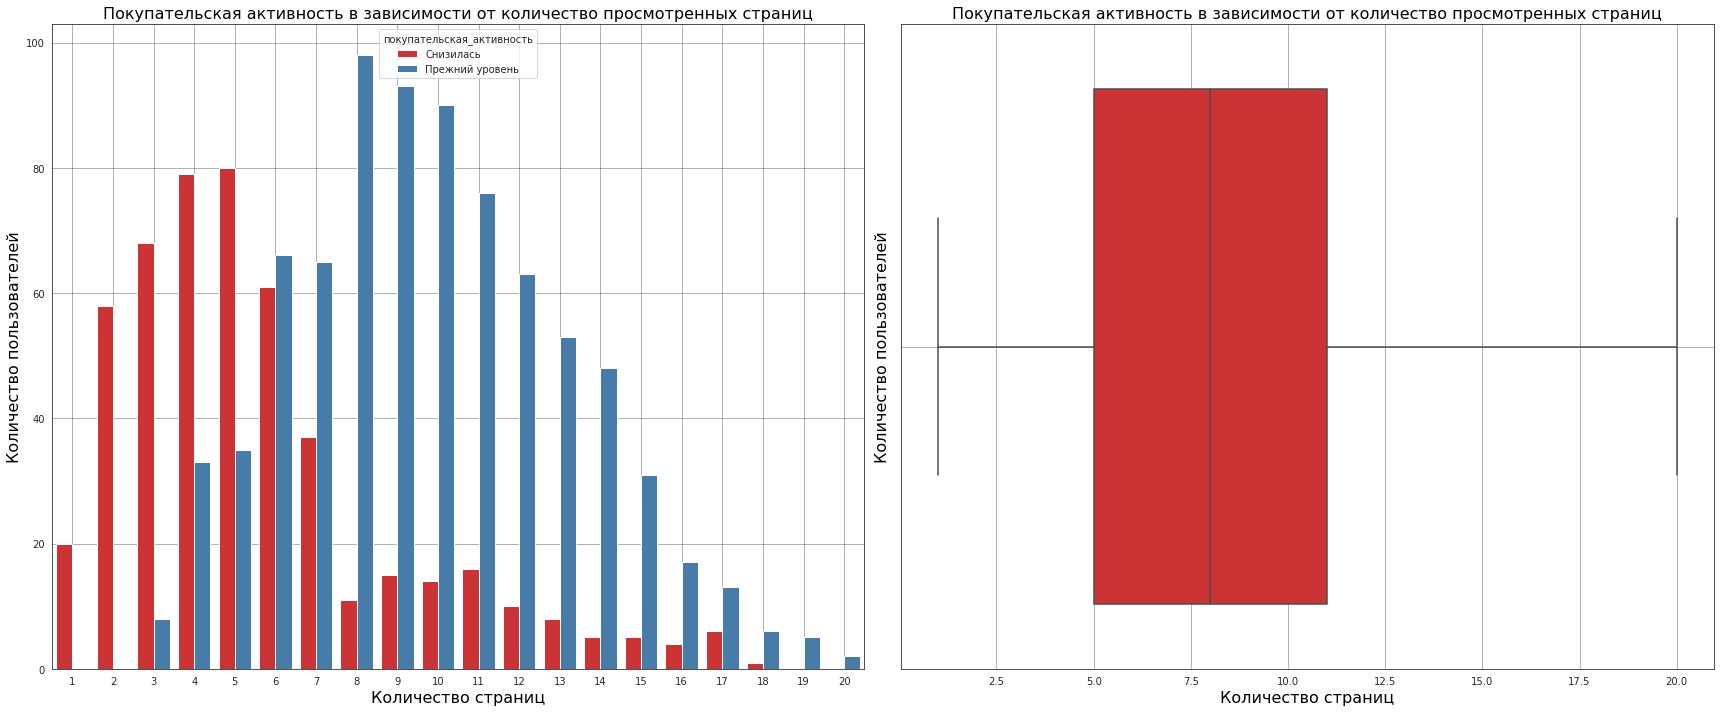

In [53]:
graf_user(df=market_file, hue='покупательская_активность', x='страниц_за_визит', word='количество просмотренных страниц', x_label='Количество страниц', y_label='Количество пользователей')

In [54]:
def graf_pie(df, lis):
    box = df[lis].value_counts()

    plt.figure(figsize=(10, 8))
    colors = sns.color_palette('Pastel1', len(box))
    plt.pie(x=box, autopct='%1.1f%%', shadow=True, colors=colors)

    plt.legend(box.index, title=lis, loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show();

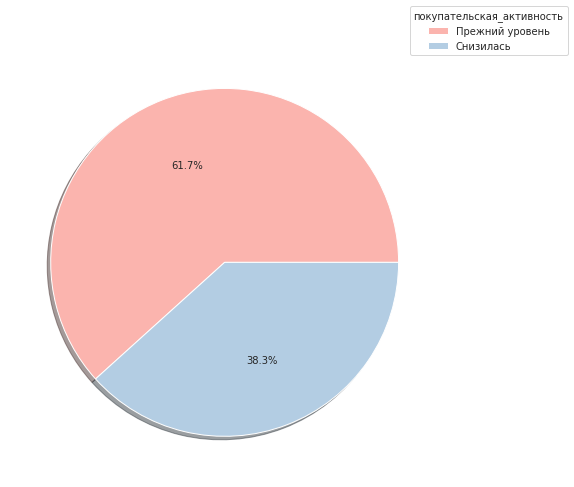

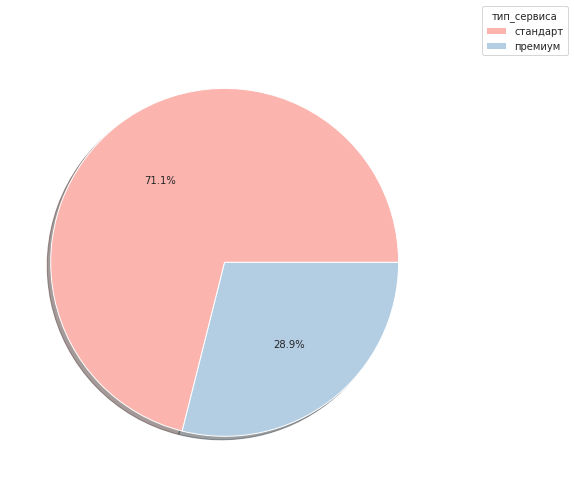

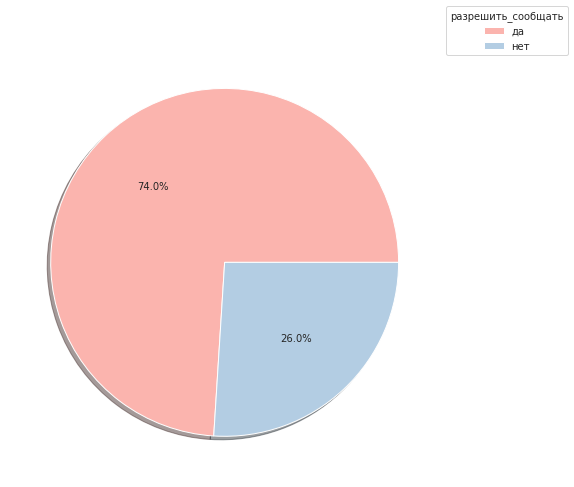

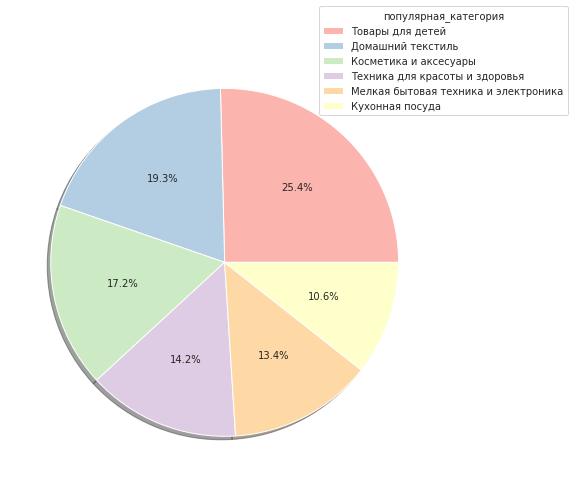

In [56]:
box = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for name in box:
    graf_pie(df=market_file, lis=name) 

- В market_file я заметил выбросы только у "акционные_покупки", но я их не трогал.
- Уже по графикам можно заметить закономерность, что кол-во рассылок повлияло на уровень активности.
- Покупательская активность снизилась у тех кто покупал только чаще акции.
- Также можно заметить, если покупатель, с самого начало не заинтересован, то он меньше посещает страниц.
- 70 % пользуются обычным типом сервиса, даже используя премиум тип сервиса у покупателей снижается активность, половина из пользователей премиум тип сервиса понизилась активность.
- Чаще всего покупают, Домашний текстиль, Товары для детей и косметика и аксессуары.

In [57]:
def box_pt(df, name):
    plt.figure(figsize=(10, 6))

    df[[name]].boxplot()

    plt.xticks(rotation=55, fontsize=15)

    plt.title('Бохплот численных значений')

    #plt.ylim(-2, 10000)
    plt.grid(True)
    plt.show();

In [58]:
market_money.describe().T

count           mean          std       min        25%       50%  \
id       3900.0  215997.500000   375.325686  215348.0  215672.75  215997.5   
выручка  3900.0    5025.696051  1777.704104       0.0    4590.15    4957.5   

               75%       max  
id       216322.25  216647.0  
выручка    5363.00  106862.2

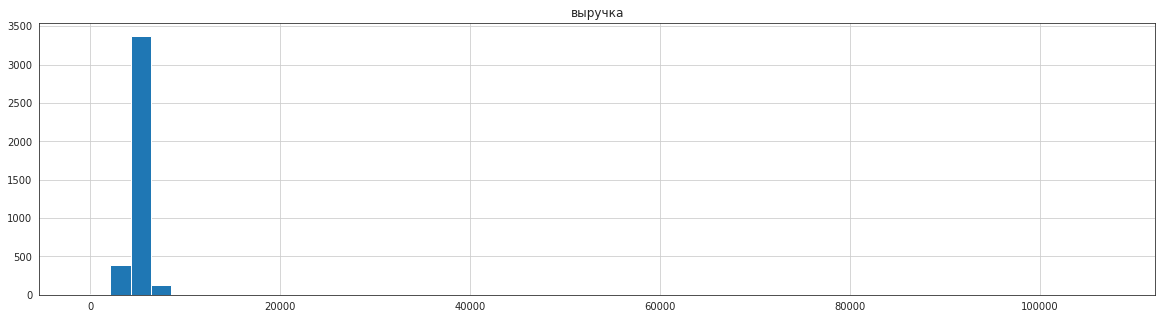

In [59]:
market_money.drop(columns=['id']).hist(figsize = (20, 5), bins=50);

In [60]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [61]:
market_money.query('выручка > 20000')

id         период   выручка
98  215380  текущий_месяц  106862.2

In [62]:
market_money = market_money[market_money['выручка'] > 1]
market_money = market_money[market_money['выручка'] < 20000]

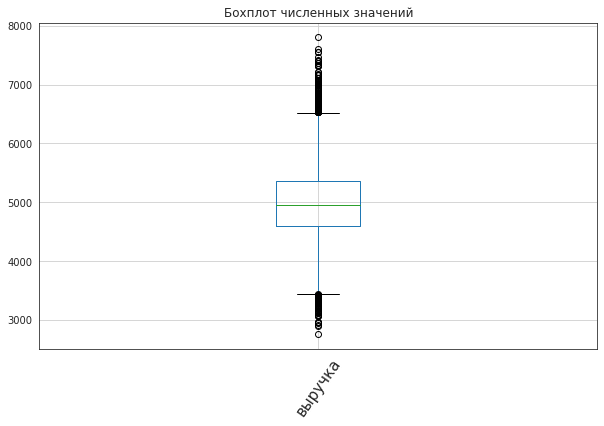

In [63]:
box_pt(df=market_money, name='выручка')

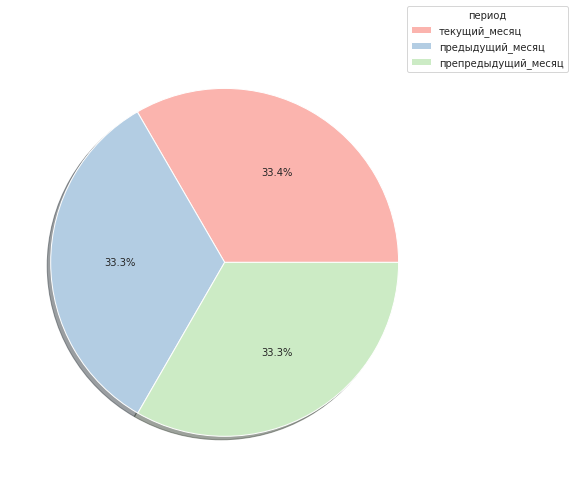

In [64]:
graf_pie(df=market_money, lis='период') 

- Замечены выбросы у выручки, я их не трогал.
- Я убрал аномалии где меньше 1 и больше 20 000
- Период прибыли взята равномерно.

In [65]:
market_time.describe().T

count           mean         std       min        25%       50%  \
id     2600.0  215997.500000  375.349754  215348.0  215672.75  215997.5   
минут  2600.0      13.336154    4.080198       4.0      10.00      13.0   

             75%       max  
id     216322.25  216647.0  
минут      16.00      23.0

In [66]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

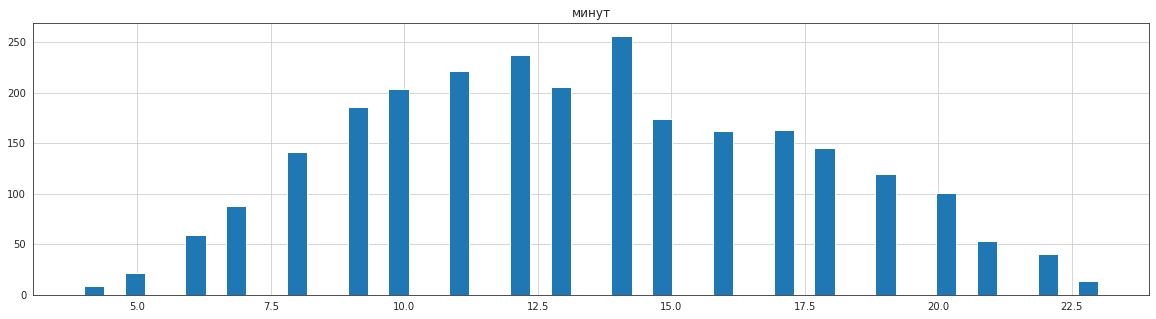

In [67]:
market_time.drop(columns=['id']).hist(figsize=(20, 5), bins=50);

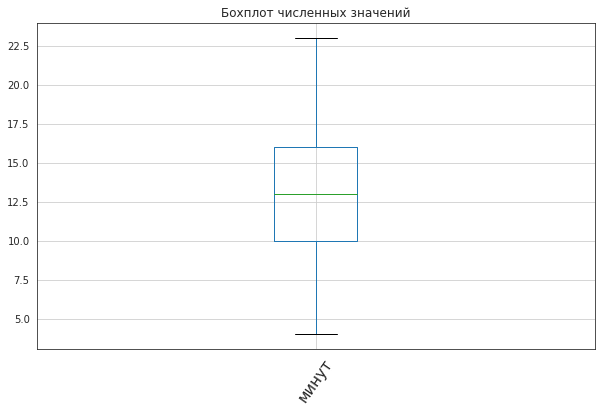

In [68]:
box_pt(df=market_time, name='минут')

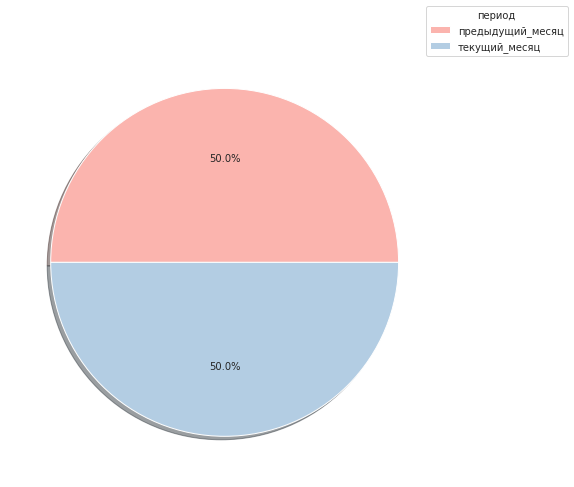

In [69]:
graf_pie(df=market_time, lis='период') 

- Проведенное время на сайте имеет нормально распределение.

In [70]:
money.describe().T

count           mean         std        min        25%         50%  \
id       1300.0  215997.500000  375.421985  215348.00  215672.75  215997.500   
прибыль  1300.0       3.996631    1.013722       0.86       3.30       4.045   

               75%        max  
id       216322.25  216647.00  
прибыль       4.67       7.43

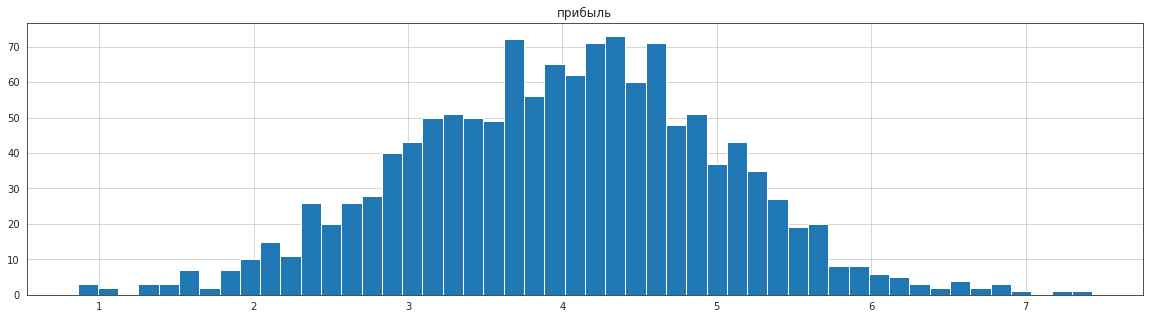

In [71]:
money.drop(columns='id').hist(figsize = (20, 5), bins=50);

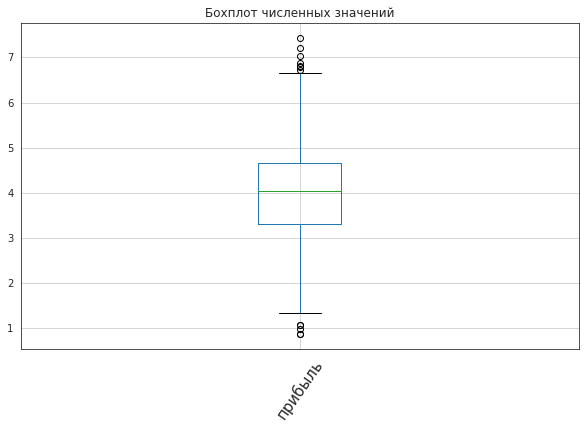

In [72]:
box_pt(df=money, name='прибыль')

- У прибыли заметны выбросы.
- Прибыль имеет нормальное распределение.

- Аномалии мы убрали.
- Разброс я не трогал.
- Если подводить итоги, то можно заметить, чтобы клиенты оставались на сайте дольше, нужно больше привлечь их внимание и дольше оставаться на сайте, минимизировать ошибку и можно заметить наплыв клииентов только из-за акций (они с самого начало покупали только из-за акций).

## Объединение таблиц

In [73]:
market = market_file.merge(market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum').rename(columns={
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
    'текущий_месяц': 'выручка_текущий_месяц',
    }).reset_index(), how='left', on='id').merge(market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum').rename(columns={
    'предыдущий_месяц': 'минут_предыдущий_месяц',
    'текущий_месяц': 'минут_текущий_месяц'}).reset_index(), how='left', on='id')

market.head(5)

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0                       NaN                          NaN   
1                    5216.0                       4472.0   
2                    5457.5                       4826.0   
3                    6158.0                       4793.0   
4                    5807.5                       4594.0   

   выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
0                 3293.1                      13                   14  
1                 4971.6                      12                   10  
2                 5058.4                       8                   13  
3                 6610.4                      11                   13  
4                 5872.5                       8                   11

In [74]:
len(market)

1300

In [75]:
market = market.dropna()

In [76]:
len(market)

1296

- Длина  df осталась после merge.
- Некоторых данных не было, я удалил их строки.

## Корреляционный анализ

In [77]:
market['выручка_тек_пред'] = market[['выручка_текущий_месяц', 'выручка_предыдущий_месяц']].mean(axis=1)
market_1 = market.drop(['id','выручка_текущий_месяц', 'выручка_предыдущий_месяц'], axis=1)
market = market.drop(['выручка_текущий_месяц', 'выручка_предыдущий_месяц'], axis=1)
market_1.head()

покупательская_активность тип_сервиса разрешить_сообщать  \
1                 Снизилась     премиум                 да   
2                 Снизилась    стандарт                нет   
3                 Снизилась    стандарт                 да   
4                 Снизилась    стандарт                нет   
5                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   
5    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   
5                                   1               1                 4   

   выручка_препредыдущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
1                       4472.0                      12                   10   
2                       4826.0                       8                   13   
3                       4793.0                      11                   13   
4                       4594.0                       8                   11   
5                       5124.0                      10                   10   

   выручка_тек_пред  
1           5093.80  
2           5257.95  
3           6384.20  
4           5840.00  
5           5063.50

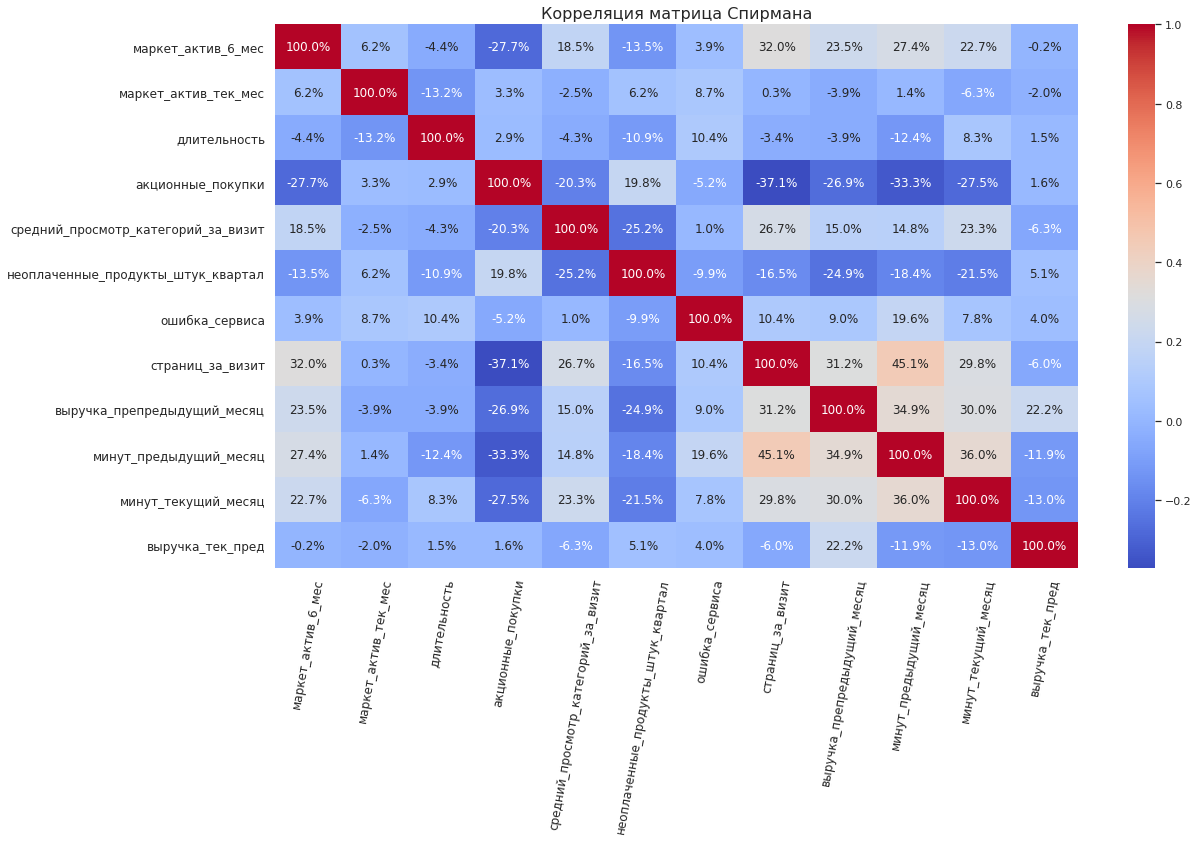

In [78]:
sns.set(rc={"figure.figsize": (18, 10)})
ax = sns.heatmap(market_1.corr(method='spearman'), annot=True, fmt='.1%', cmap="coolwarm")

ax.tick_params(axis='x', labelrotation=80, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.title('Корреляция матрица Спирмана', fontsize=16);

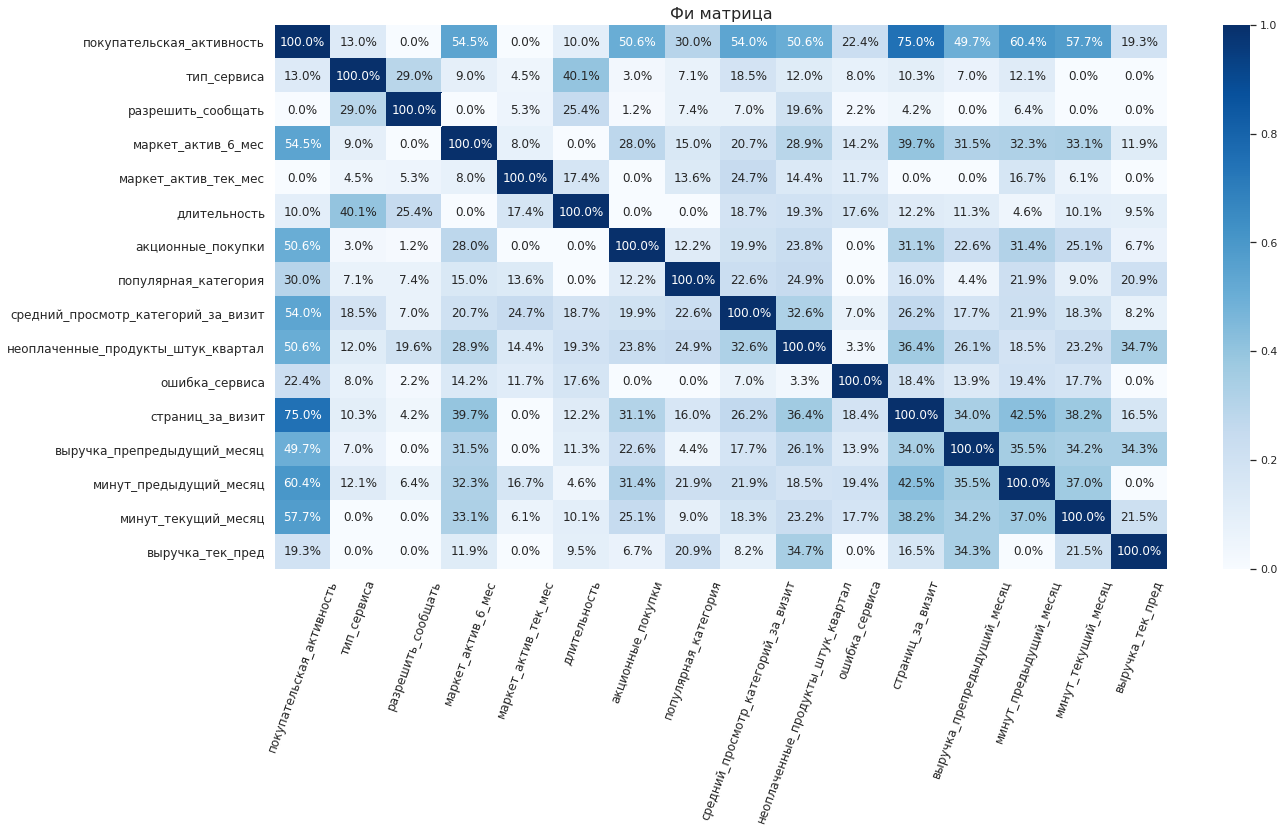

In [79]:
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(market_1.phik_matrix(interval_cols=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_тек_пред', 'минут_текущий_месяц']), annot=True, fmt='.1%', cmap="Blues")

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.title('Фи матрица', fontsize=16);

In [80]:
def graph_corr(df, x, y):
    plt.figure(figsize=(13, 8))
    sns.scatterplot(data=df, x=x, y=y, hue='покупательская_активность', style='покупательская_активность', s=100, palette='deep')

    df_corr = round(df[x].corr(df[y], method='spearman'), 3)
    
    plt.title('Диаграммы рассеяния между {x} и {y}'.format(x=x, y=y), fontsize=16, fontweight="normal", color='black')
    plt.xlabel('{x} \n Корреляция Спирмана {corr}'.format(x=x, corr=df_corr), fontsize=14, fontweight="normal", color='black')
    plt.ylabel('{y}'.format(y=y), fontsize=14, fontweight="normal", color='black')
    plt.grid(True)
    
    plt.tight_layout()
    
    plt.show();

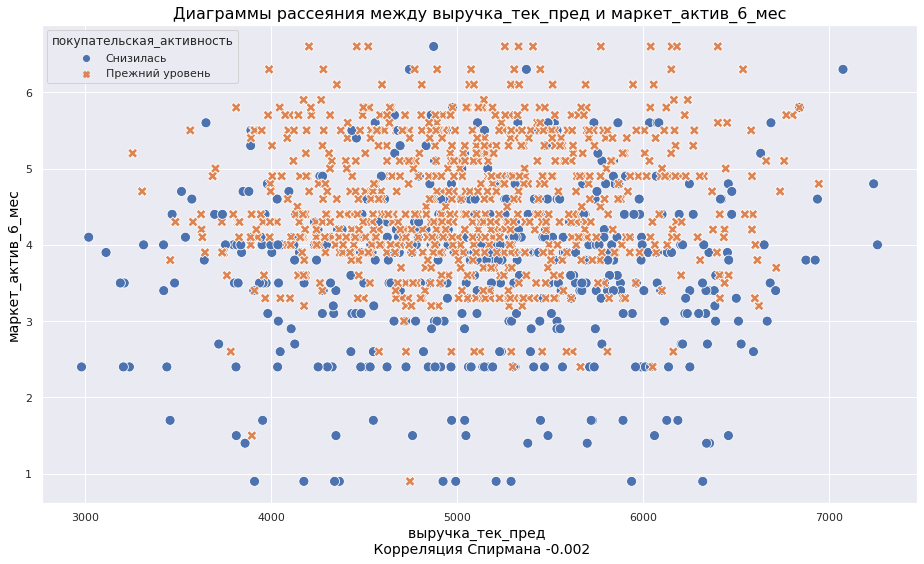

In [81]:
graph_corr(df=market_1, x='выручка_тек_пред', y='маркет_актив_6_мес')

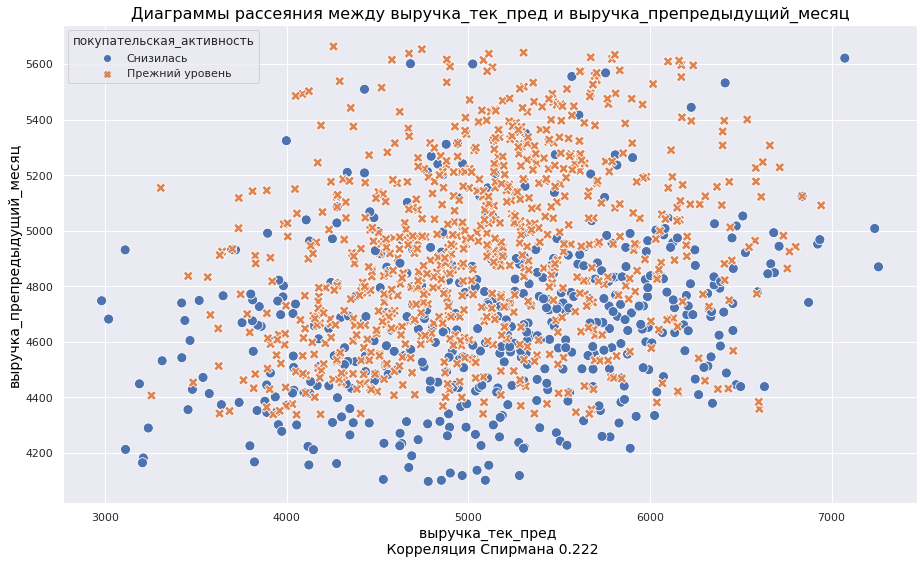

In [82]:
graph_corr(df=market_1, x='выручка_тек_пред', y='выручка_препредыдущий_месяц')

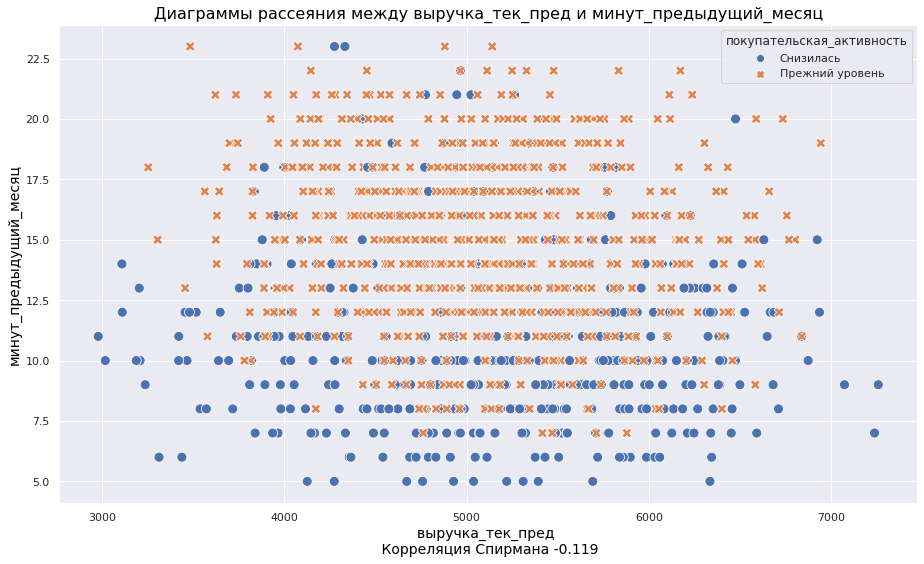

In [83]:
graph_corr(df=market_1, x='выручка_тек_пред', y='минут_предыдущий_месяц')

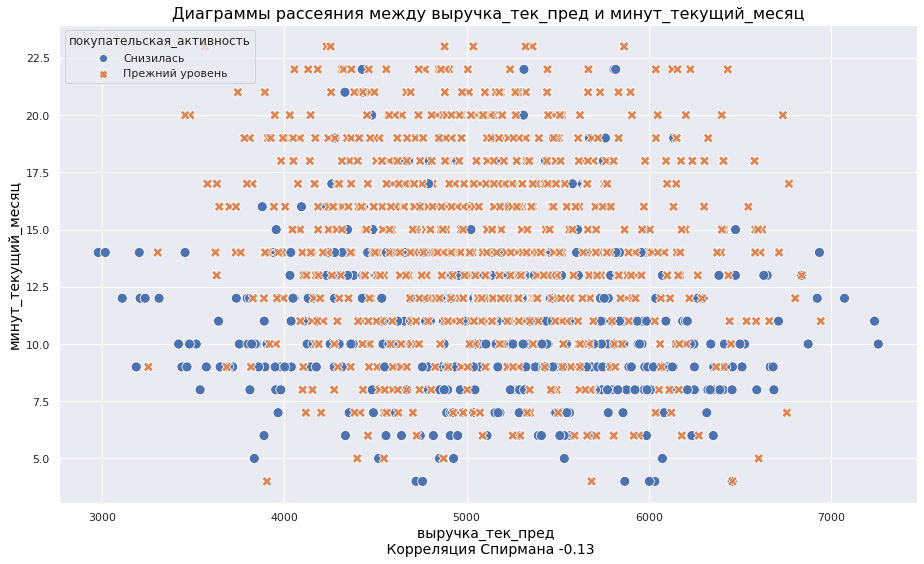

In [84]:
graph_corr(df=market_1, x='выручка_тек_пред', y='минут_текущий_месяц')

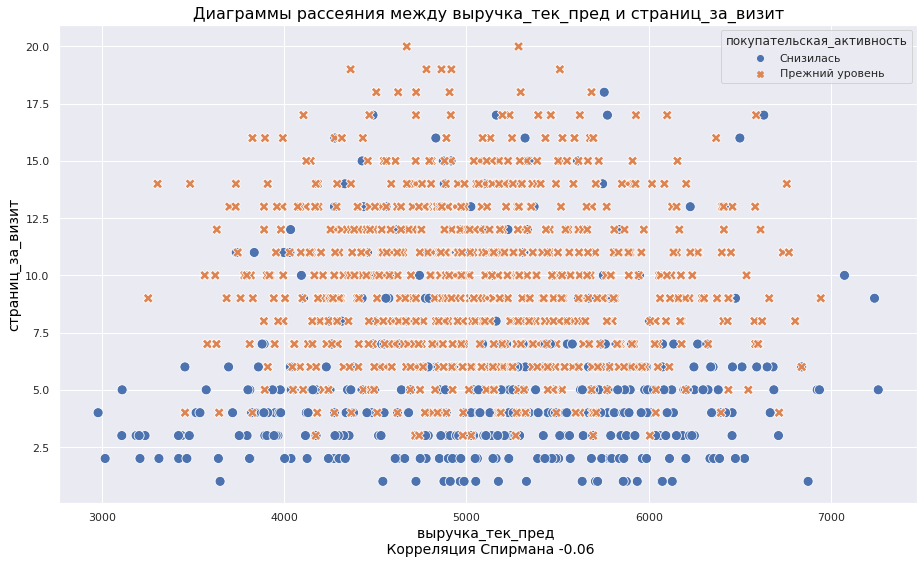

In [85]:
graph_corr(df=market_1, x='выручка_тек_пред', y='страниц_за_визит')

- По матрице фи на покупательскую активность влияет сильнее всего рассылки, акционные покупки, длительность просмотра страницы, неоплаченные покупки, кол-во посещенных страниц, выручка за предпредыщий месяц, минут за пред месяц и минут текущего месяца.
- По корреляции спирмана есть мультиколиниарность выручка за тек и пред месяц, поэтому мы их обьеденели.
- Также я хотел отдельно посмотреть как влияет на выручку в разрезе покупательской активности, единственное, что я заметил активные пользователи и не активные, разьедены как бы по подгруппам, на график можно увидеть, где проходит грань между ними.

## Использование пайплайнов

In [86]:
market = market.set_index('id')
market.head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   

        выручка_препредыдущий_месяц  минут_предыдущий_месяц  \
id                                                            
215349                       4472.0                      12   
215350                       4826.0                       8   
215351                       4793.0                      11   

        минут_текущий_месяц  выручка_тек_пред  
id                                             
215349                   10           5093.80  
215350                   13           5257.95  
215351                   13           6384.20

In [87]:
market['акционные_покупки_частота'] = np.where(market['акционные_покупки'] >= 0.5, 'Часто покупает по акции', 'Редко покупает по акции')
market.head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   

        выручка_препредыдущий_месяц  минут_предыдущий_месяц  \
id                                                            
215349                       4472.0                      12   
215350                       4826.0                       8   
215351                       4793.0                      11   

        минут_текущий_месяц  выручка_тек_пред акционные_покупки_частота  
id                                                                       
215349                   10           5093.80   Часто покупает по акции  
215350                   13           5257.95   Редко покупает по акции  
215351                   13           6384.20   Часто покупает по акции

In [88]:
X = market.drop(['покупательская_активность'], axis=1)

y = market['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE , random_state = RANDOM_STATE, stratify = y)


label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_test_le = label_encoder.transform(y_test)
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

word_col = ['тип_сервиса', 
            'популярная_категория',
           'разрешить_сообщать',
           'акционные_покупки_частота']

num_col = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц', 'выручка_тек_пред']


In [89]:
label_mapping

{0: 'Прежний уровень', 1: 'Снизилась'}

In [90]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', sparse=False))
    ]
)

In [91]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, word_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [92]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [93]:
param_grid = [
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)]
    },
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models': [KNeighborsClassifier()]
    },
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models': [SVC(random_state=RANDOM_STATE, probability=True)]
    },
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models': [LogisticRegression(random_state=RANDOM_STATE)]
    }
]

In [94]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [95]:
import warnings

warnings.filterwarnings("ignore")

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid.fit(X_train, y_train_le)

print('Лучшая модель и её параметры:\n', grid.best_params_)
print('Метрика ROC-AUC для лучшей модели:', round(grid.best_score_, 3))

Лучшая модель и её параметры:
 {'models': SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler()}
Метрика ROC-AUC для лучшей модели: 0.909


In [96]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

print("Dummy Classifier:", accuracy_score(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier: 0.6203703703703703
                 precision    recall  f1-score   support

Прежний уровень       0.62      1.00      0.77       201
      Снизилась       0.00      0.00      0.00       123

       accuracy                           0.62       324
      macro avg       0.31      0.50      0.38       324
   weighted avg       0.38      0.62      0.48       324



In [98]:
y_pred = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.9117


На текущем этапе исследования была создана и обучена модель для выявления снижения активности покупателей сервиса. Наилучшие результаты продемонстрировала модель SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler().

Метрика ROC AUC для тестовой выборки составила 0.909, а для обучающей 0.9117.
Я выбрал ROC AUC поскольку она устойчива к выбросам и подходит как для recall и precission.
Я использовал метрику ROC AUC из-за ее устойчивости к дисбалансу, лучше подходит для сравнении моделей
Эти результаты очень хорошие, и наша модель эффективно справляется с задачей предсказания.

Здесь стоит вопрос, что важнее для бизнеса, на такую метрику мы и будем обучать модель,  recall подходит, чтобы не упустить клиентов, больше будет ложных срабатываний и наоборот. 

## Анализ важности признаков

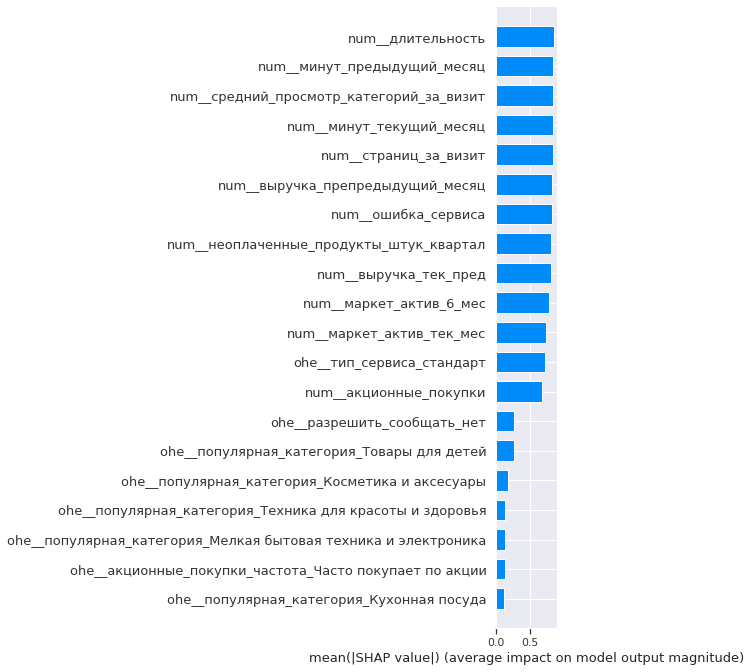

In [99]:
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)

model = grid.best_estimator_['models'].fit(X_encoded, y_train)
X_test_encoded = grid.best_estimator_['preprocessor'].transform(X_test)

explainer = shap.PermutationExplainer(model, X_encoded)
labels = grid.best_estimator_['preprocessor'].get_feature_names_out()

shap.summary_plot(X_encoded, plot_type='bar', feature_names=labels)

Основными признаками являются: время с момента регистрации пользователя, количество минут, проведенных на сайте, число категорий, посещенных за один визит, и общее количество просмотренных страниц. На самом деле имеется множество признаков, которые обладают схожей степенью важности, начиная от длительности и заканчивая количеством покупок по акциям. Все эти характеристики можно применять для сегментации покупателей.

## Сегментация покупателей

In [100]:
label_mapping

{0: 'Прежний уровень', 1: 'Снизилась'}

In [101]:
X_test['вероятность_снижение_активности'] = grid.predict_proba(X_test)[:,1]
X_train['вероятность_снижение_активности'] = grid.predict_proba(X_train)[:,1]
df_full = pd.concat([X_train, X_test])

In [102]:
money = money.set_index('id')
df_market_money = df_full.merge(money, on='id', how='left')
df_market_money.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215858    стандарт                 да                 5.5   
215361    стандарт                 да                 5.1   
215884    стандарт                 да                 4.3   
216564    стандарт                 да                 5.6   
215715     премиум                 да                 3.6   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215858                     4           510               0.15   
215361                     4           199               0.23   
215884                     5           997               0.17   
216564                     4           342               0.94   
215715                     5           873               0.39   

                        популярная_категория  \
id                                             
215858  Мелкая бытовая техника и электроника   
215361        Техника для красоты и здоровья   
215884  Мелкая бытовая техника и электроника   
216564                       Кухонная посуда   
215715                      Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215858                                    2   
215361                                    4   
215884                                    5   
216564                                    2   
215715                                    3   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215858                                   4               7                16   
215361                                   5               2                 3   
215884                                   1               3                11   
216564                                   7               5                 8   
215715                                   2               2                 5   

        выручка_препредыдущий_месяц  минут_предыдущий_месяц  \
id                                                            
215858                       4347.0                      20   
215361                       4597.0                      11   
215884                       4626.0                      13   
216564                       5269.0                      14   
215715                       4691.0                      10   

        минут_текущий_месяц  выручка_тек_пред акционные_покупки_частота  \
id                                                                        
215858                    6           5592.35   Редко покупает по акции   
215361                   13           5094.85   Редко покупает по акции   
215884                   10           3955.70   Редко покупает по акции   
216564                   19           4848.10   Часто покупает по акции   
215715                   10           4158.00   Редко покупает по акции   

        вероятность_снижение_активности  прибыль  
id                                                
215858                         0.084415     4.37  
215361                         0.712399     4.03  
215884                         0.098304     4.37  
216564                         0.441575     5.58  
215715                         0.973848     4.87

In [103]:
df_market_money['предсказание_снижении_активности'] = np.where(df_market_money['вероятность_снижение_активности'] >= 0.5, 'Скоро снизиться', 'Без изменений')

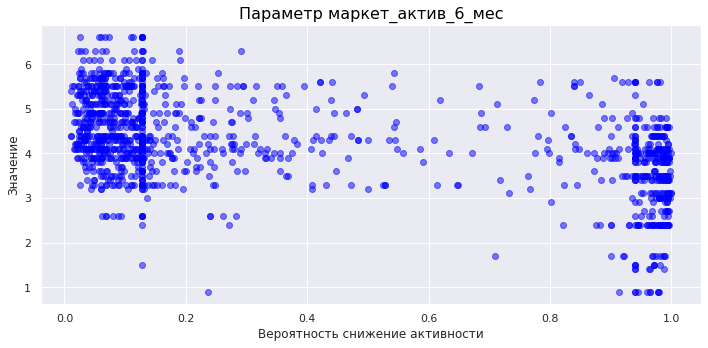

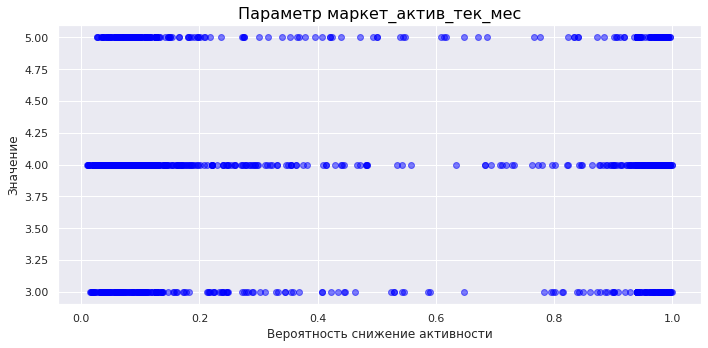

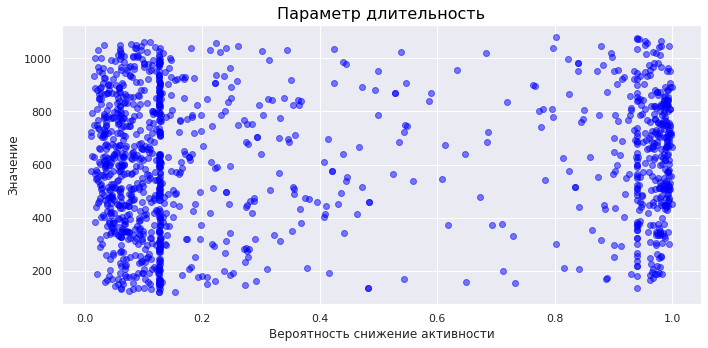

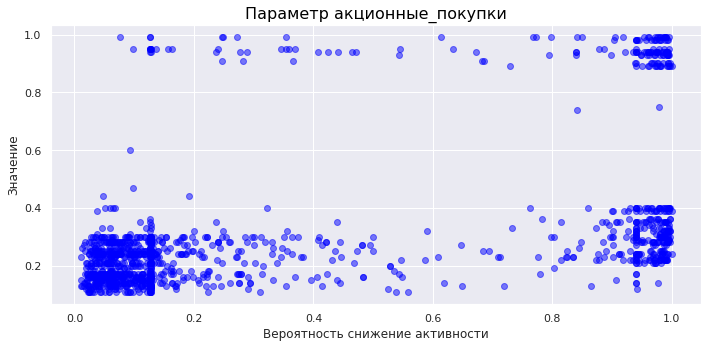

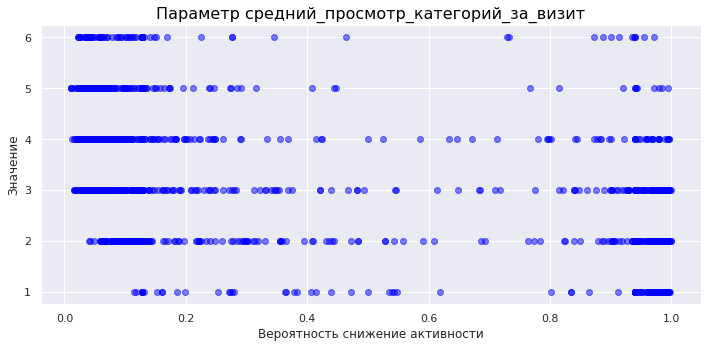

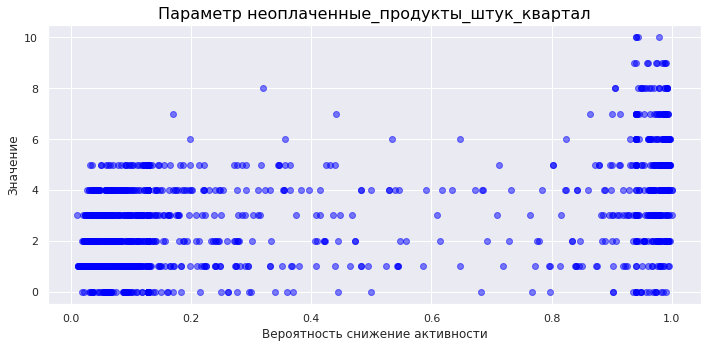

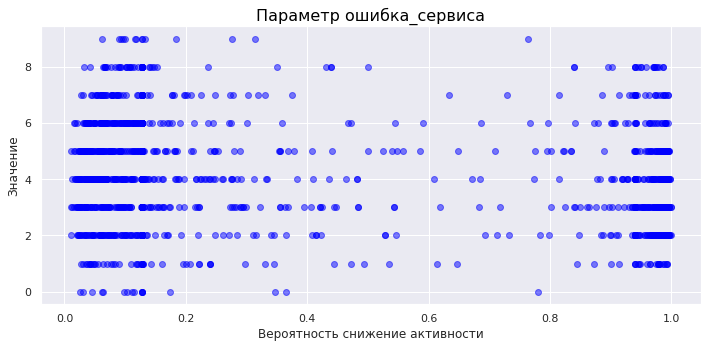

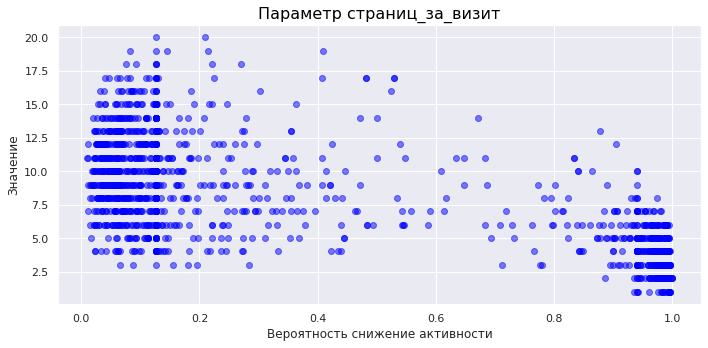

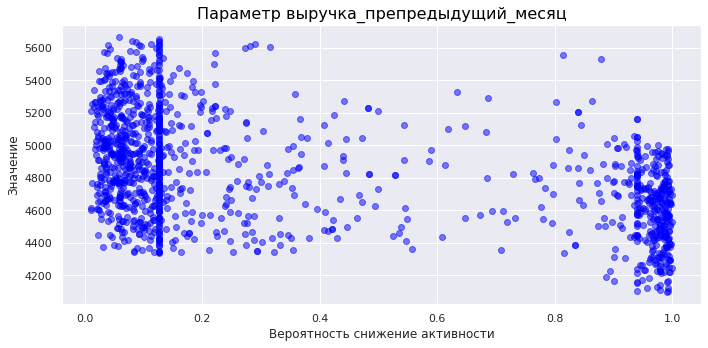

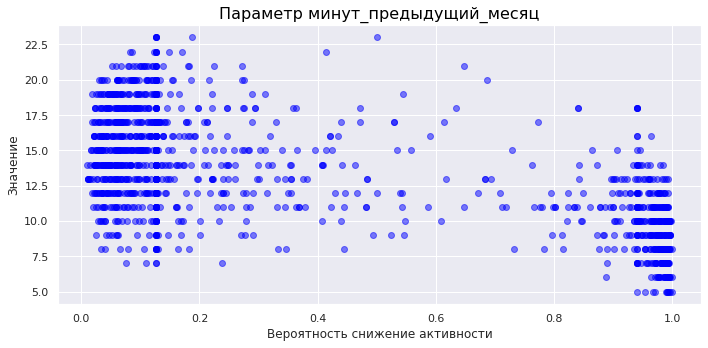

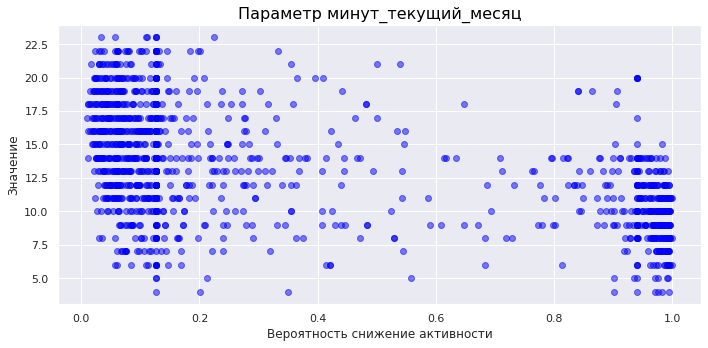

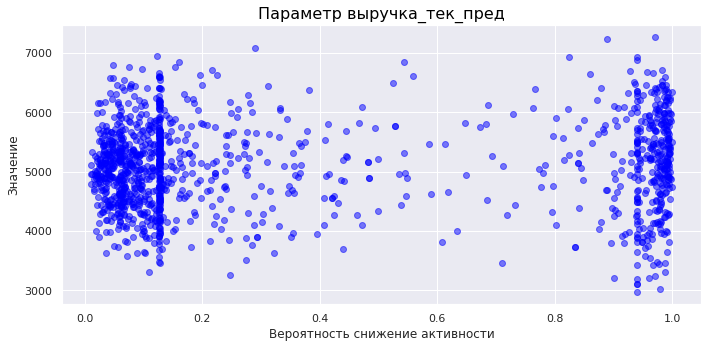

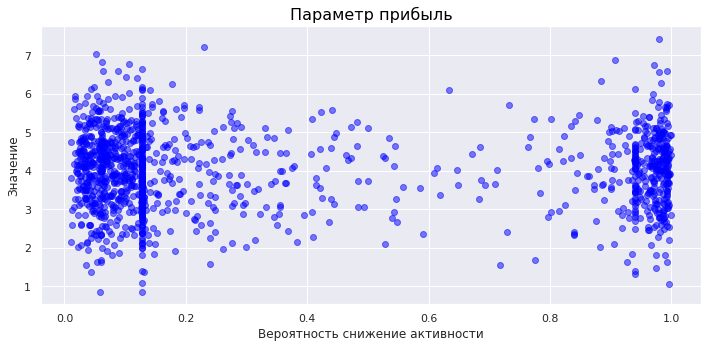

In [104]:
def graph_distribution(df, y):
    plt.figure(figsize=(10, 5))
    plt.scatter(x=df['вероятность_снижение_активности'], y=df[y], alpha=0.5, c='blue')
    plt.title('Параметр {y}'.format(y=y), fontsize=16, fontweight="normal", color='black')
    plt.xlabel('Вероятность снижение активности')
    plt.ylabel('Значение')
    plt.grid(True)
    
    plt.tight_layout()
    
    plt.show();

box = ['маркет_актив_6_мес', 
        'маркет_актив_тек_мес', 
        'длительность', 
        'акционные_покупки', 
        'средний_просмотр_категорий_за_визит', 
        'неоплаченные_продукты_штук_квартал', 
        'ошибка_сервиса', 
        'страниц_за_визит', 
        'выручка_препредыдущий_месяц', 
        'минут_предыдущий_месяц', 
        'минут_текущий_месяц', 
        'выручка_тек_пред',
        'прибыль']

for y in box:
    graph_distribution(df=df_market_money, y=y)

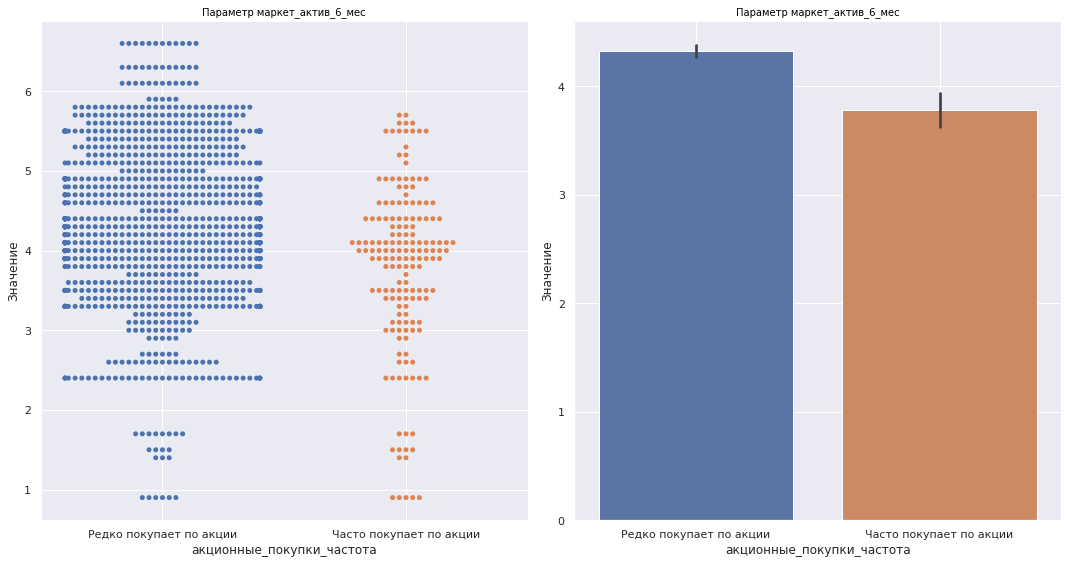

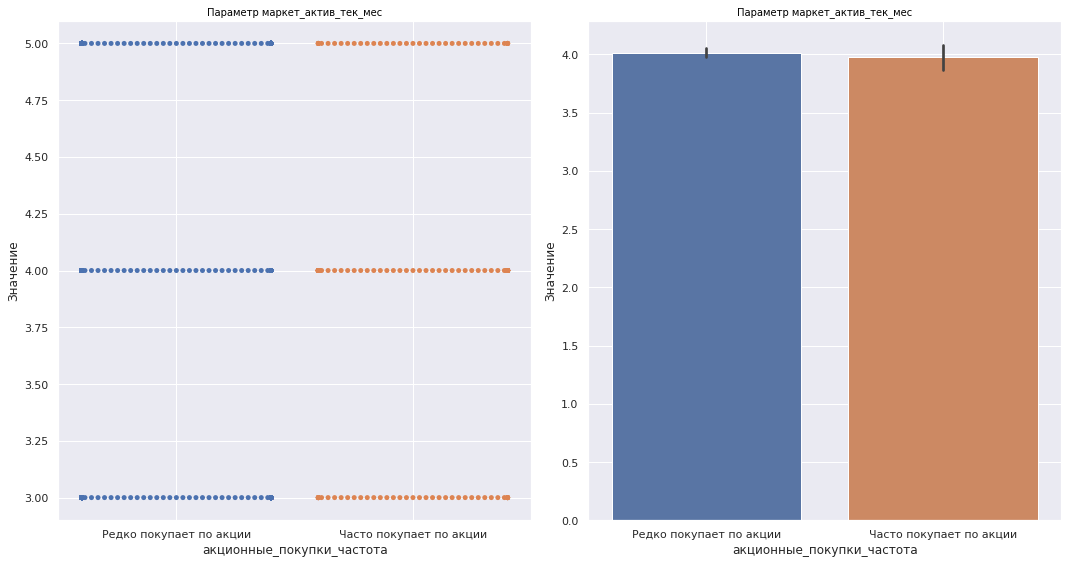

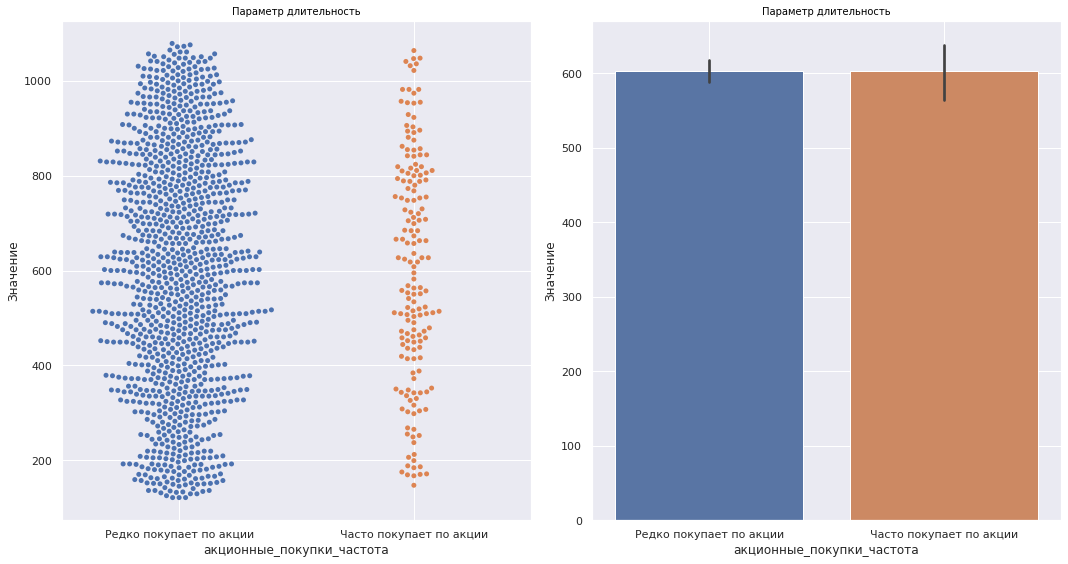

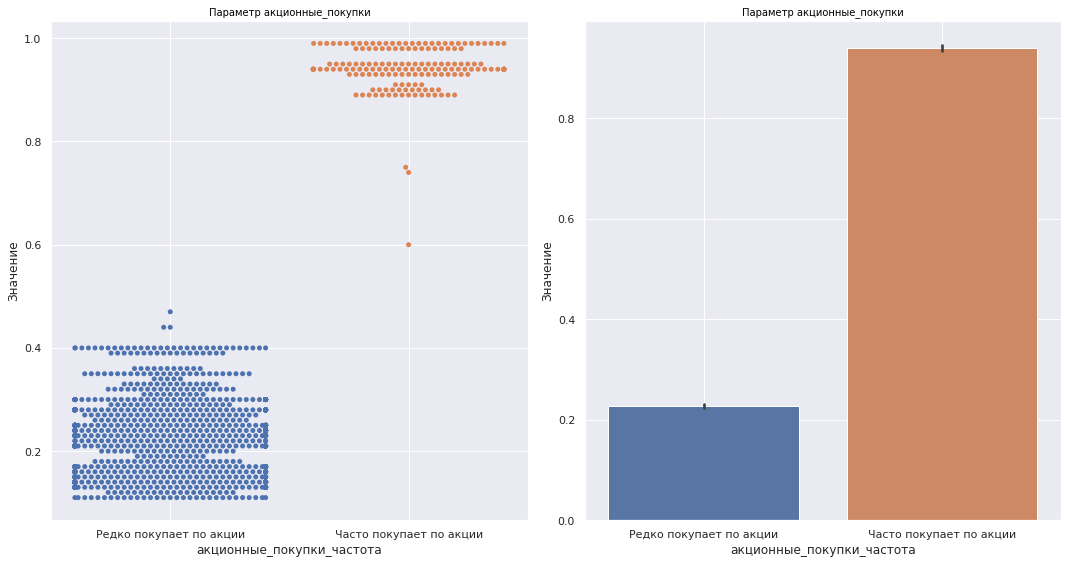

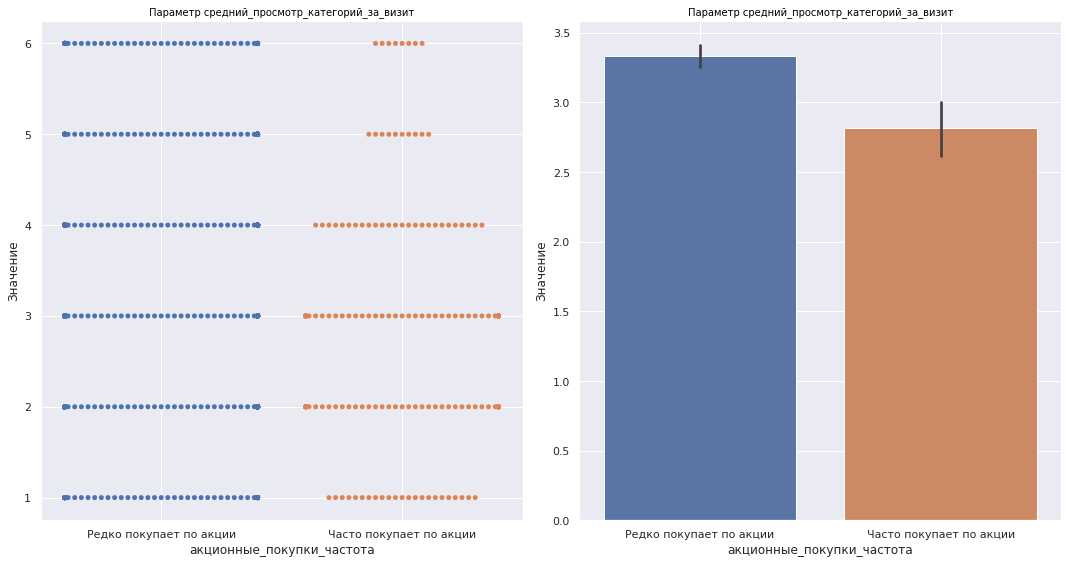

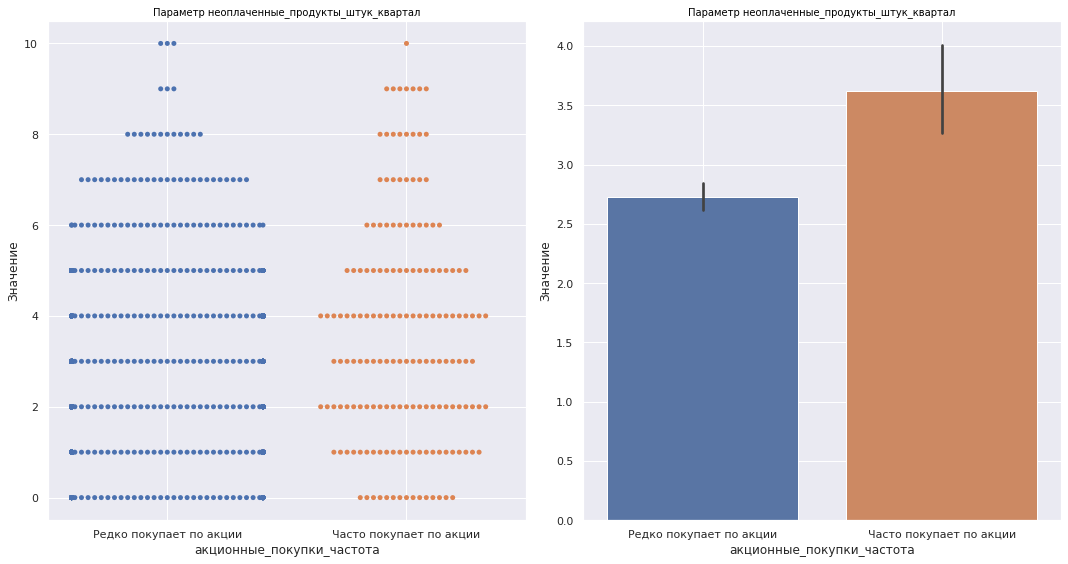

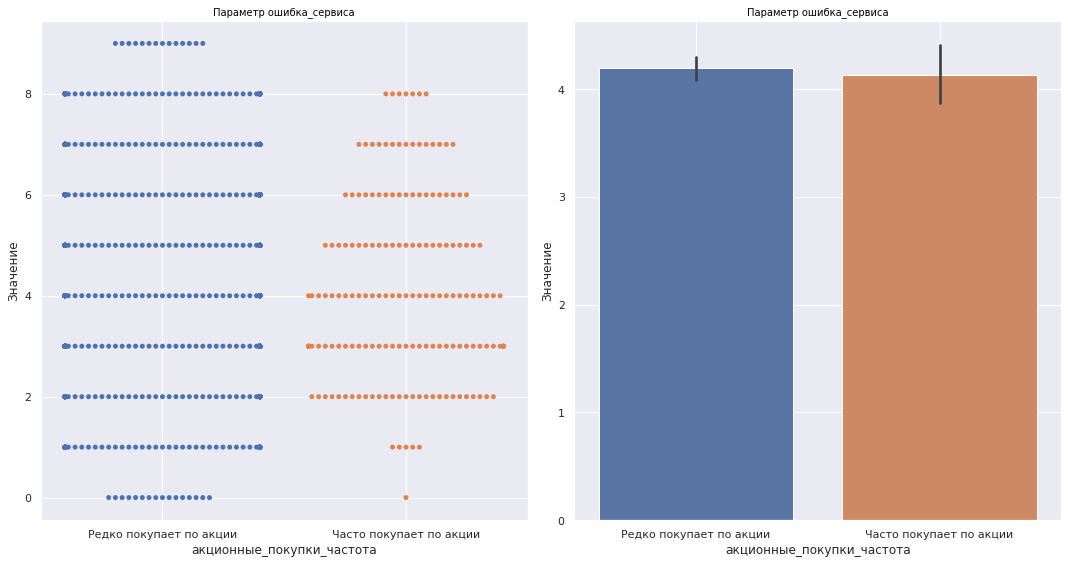

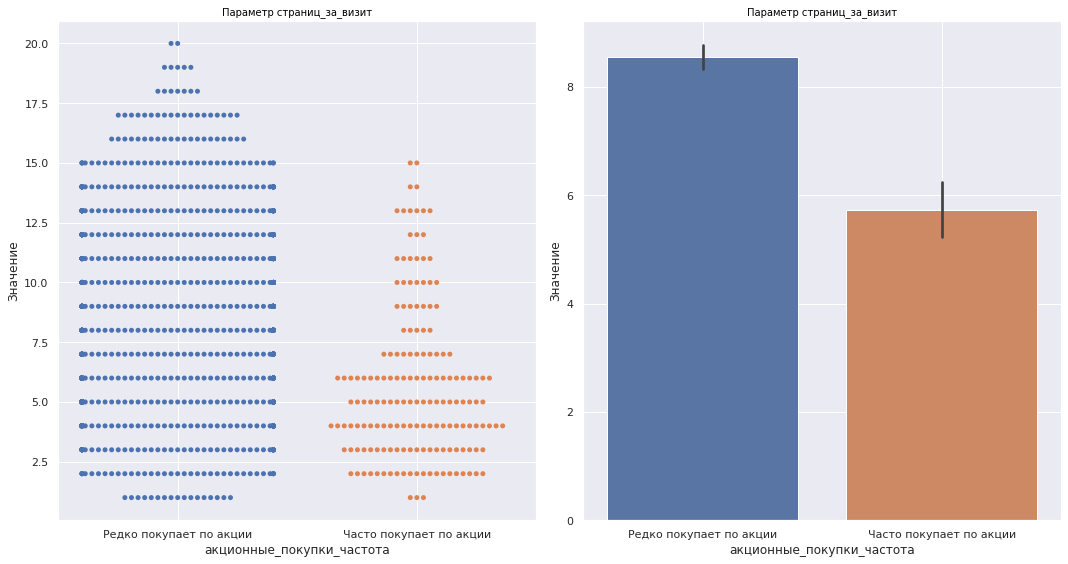

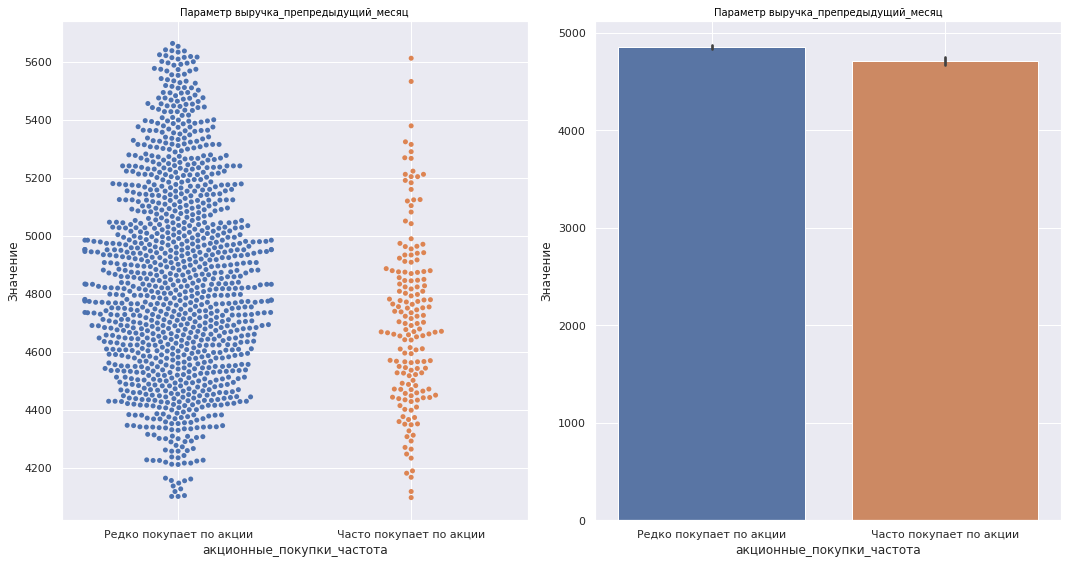

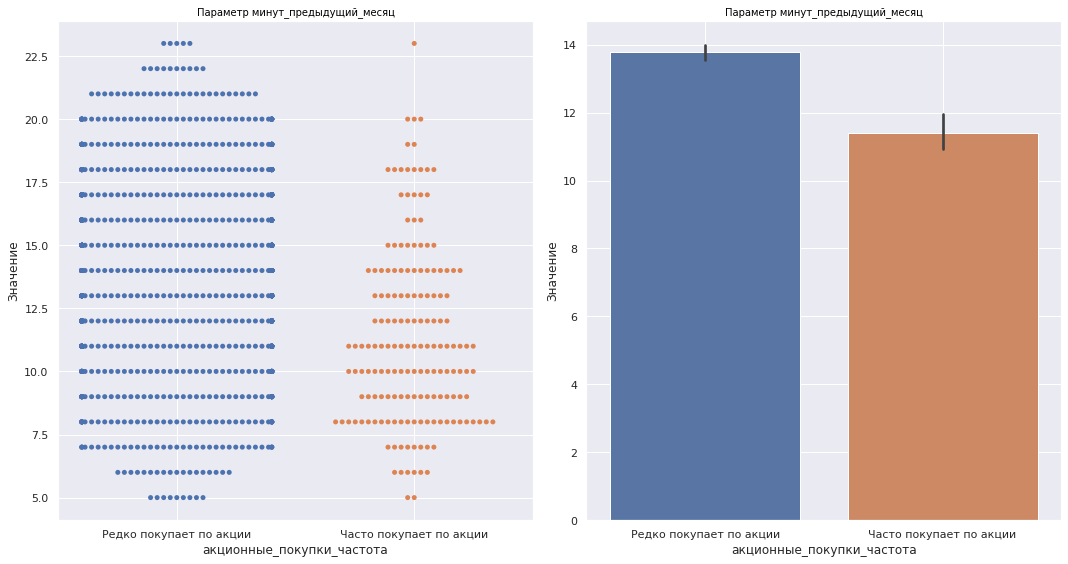

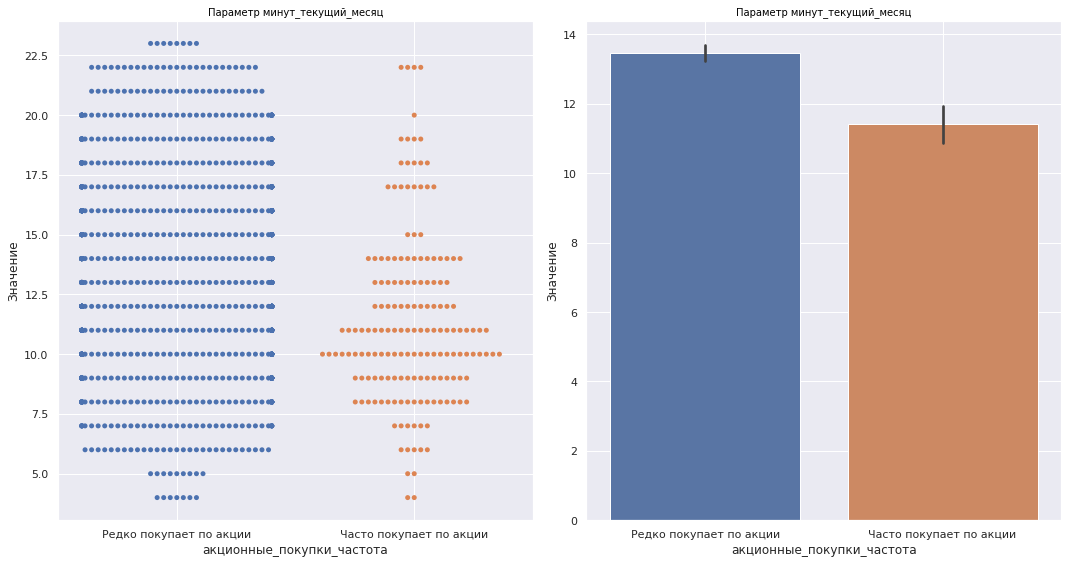

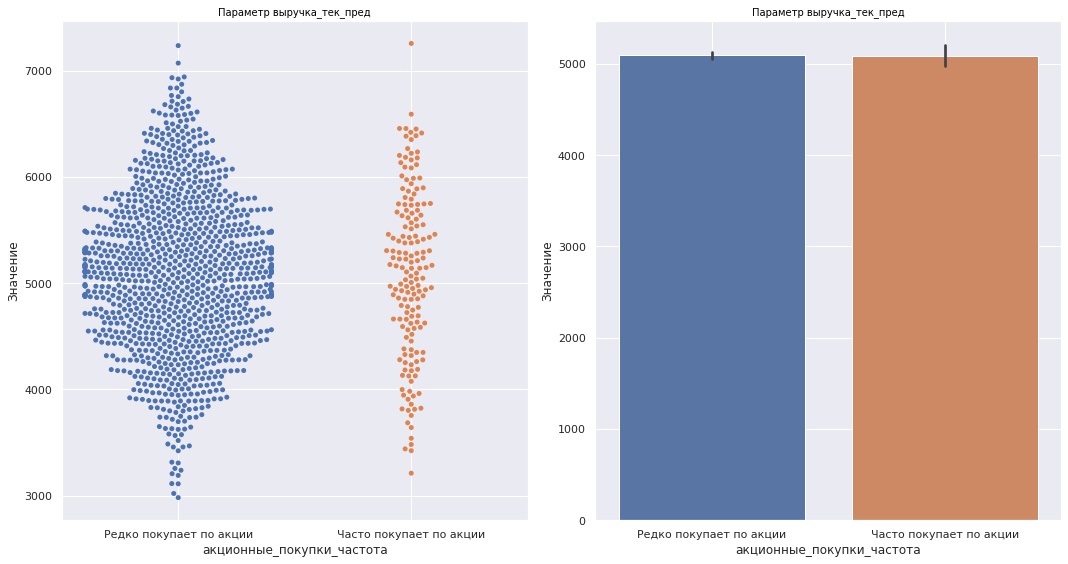

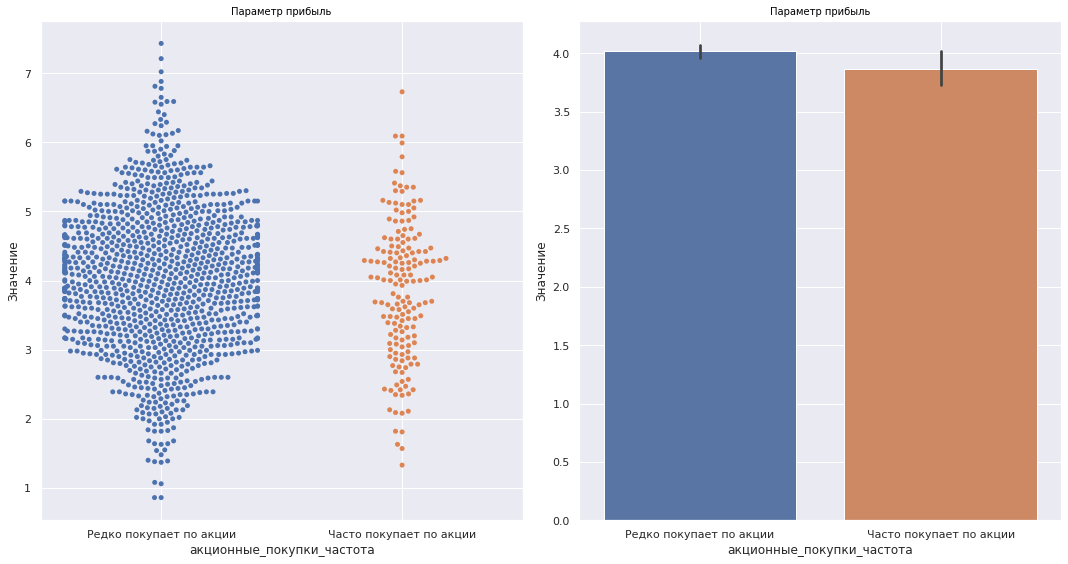

In [105]:
def graph_distribution(df, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    sns.swarmplot(x=df['акционные_покупки_частота'], y=df[y], data=df, ax=axes[0])
    
    axes[0].set_title(f'Параметр {y}', fontsize=10, fontweight="normal", color='black')
    axes[0].set_ylabel('Значение')
    axes[0].grid(True)
    
    sns.barplot(x=df['акционные_покупки_частота'], y=df[y], data=df, ax=axes[1])
    
    axes[1].set_title(f'Параметр {y}', fontsize=10, fontweight="normal", color='black')
    axes[1].set_ylabel('Значение')
    axes[1].grid(True)

    
    plt.tight_layout()
    plt.show()


for y in box:
    graph_distribution(df=df_market_money, y=y)

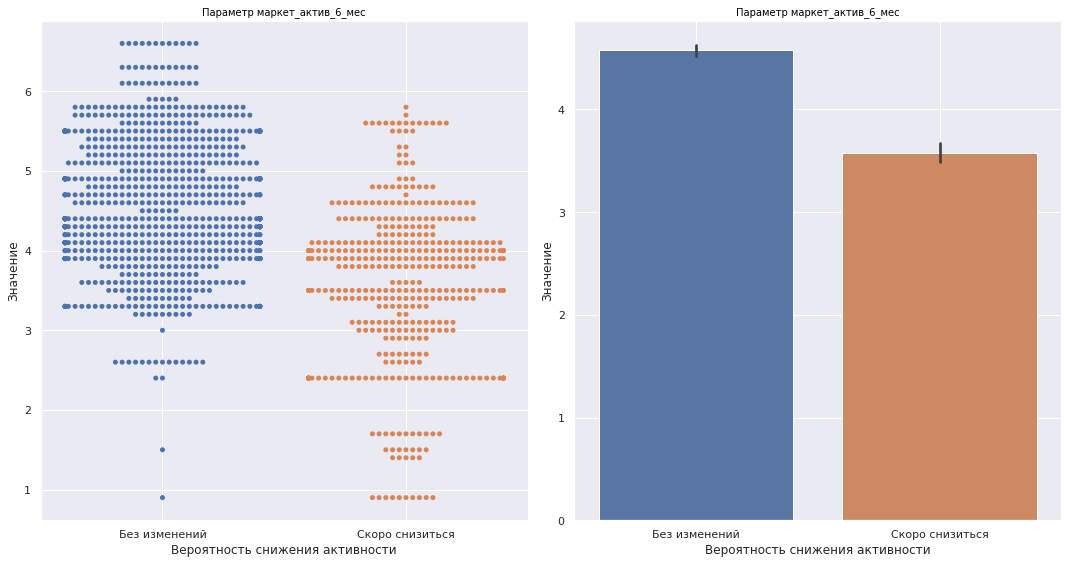

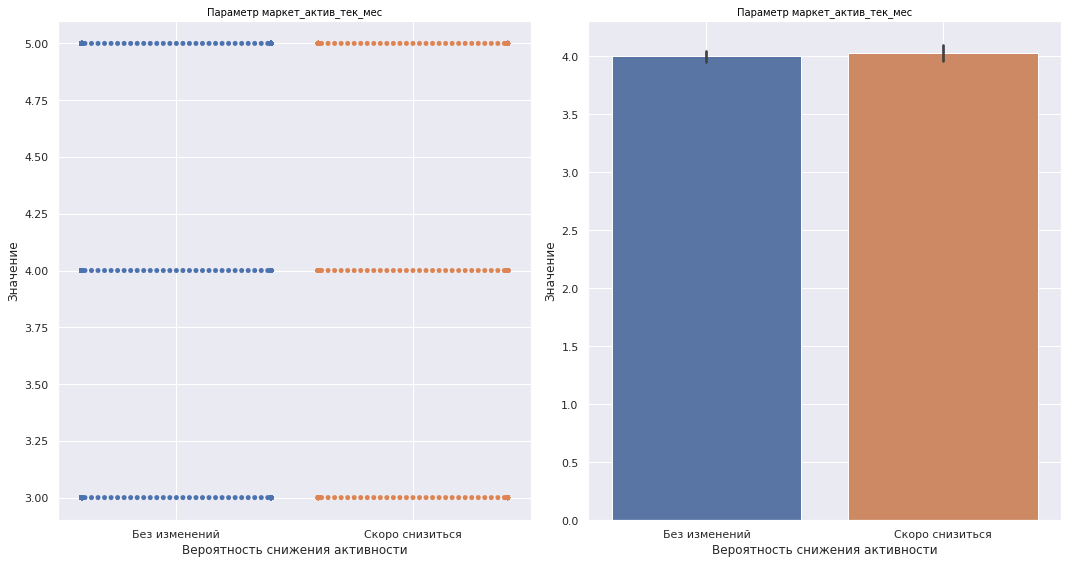

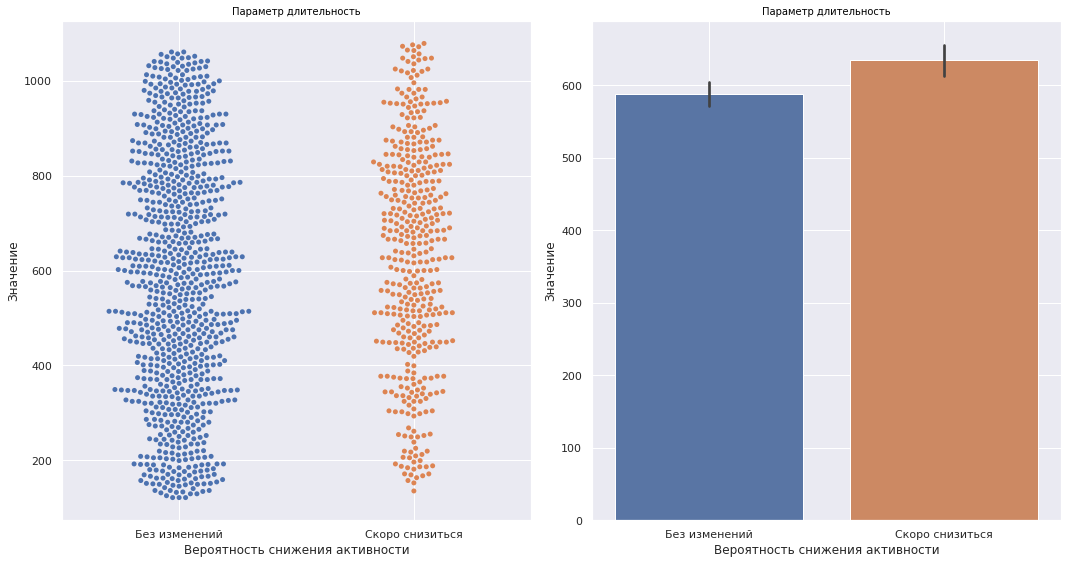

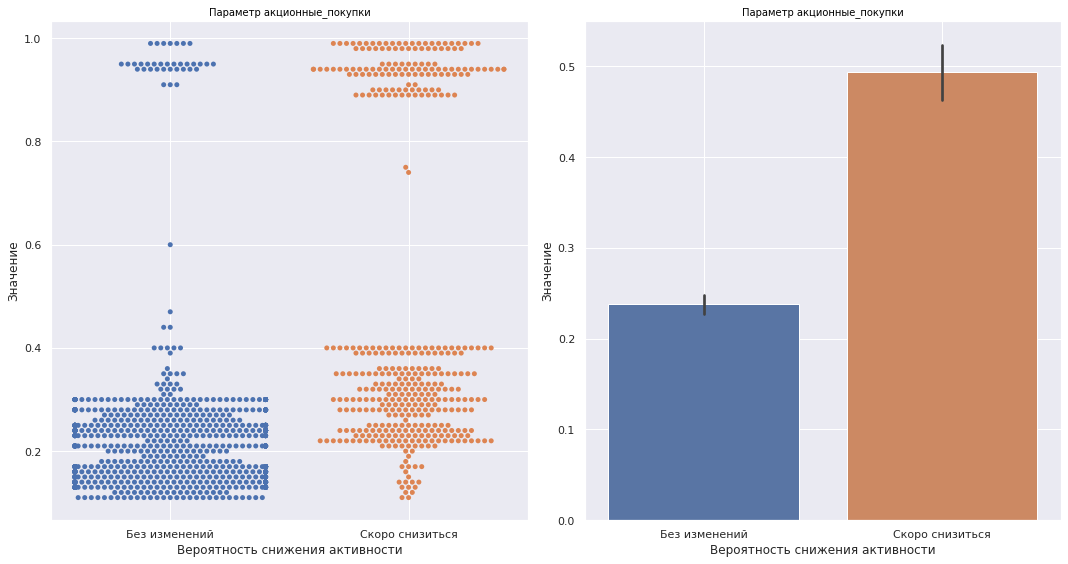

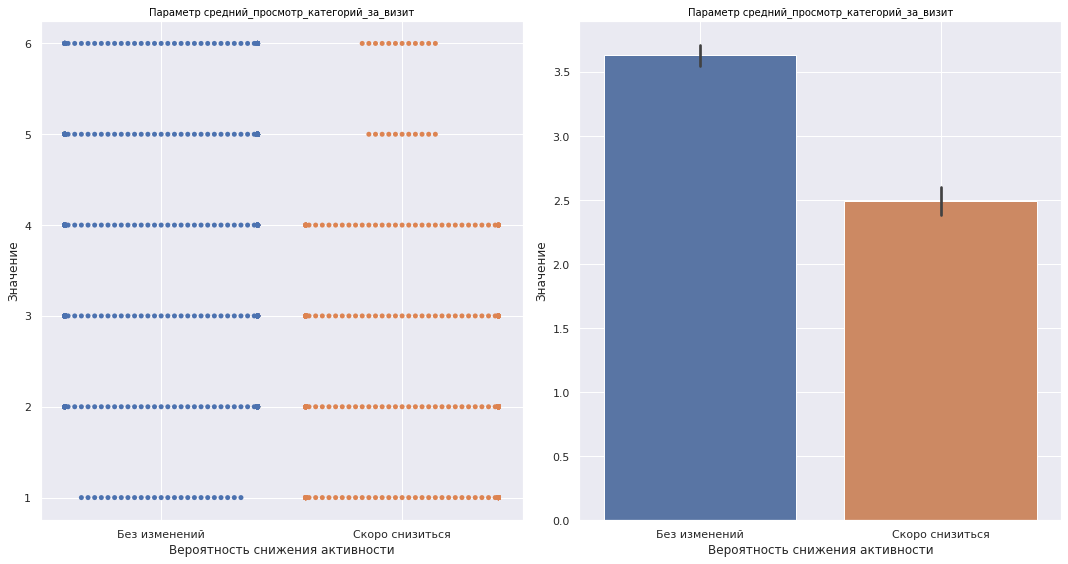

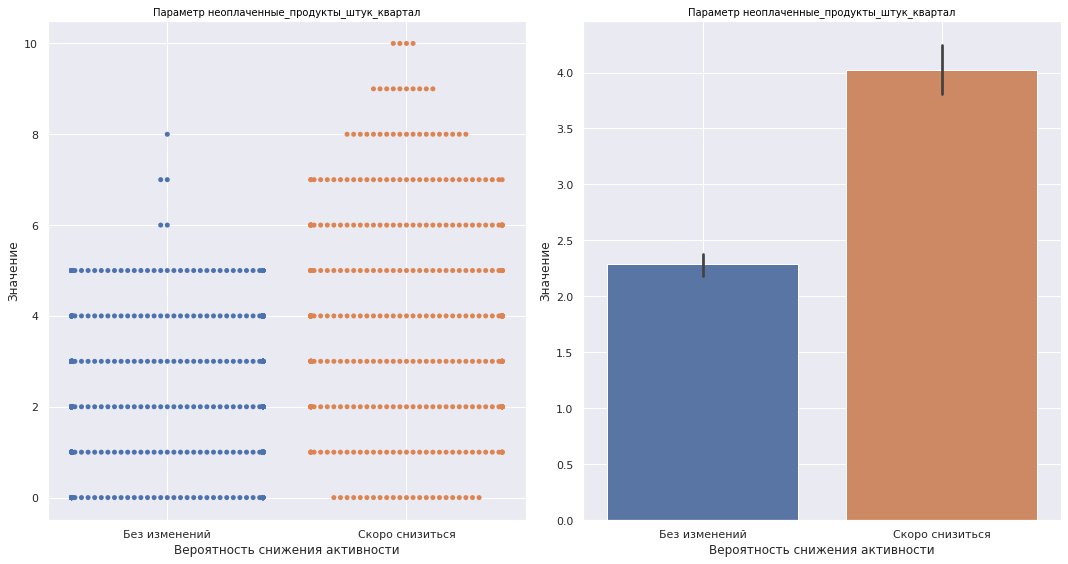

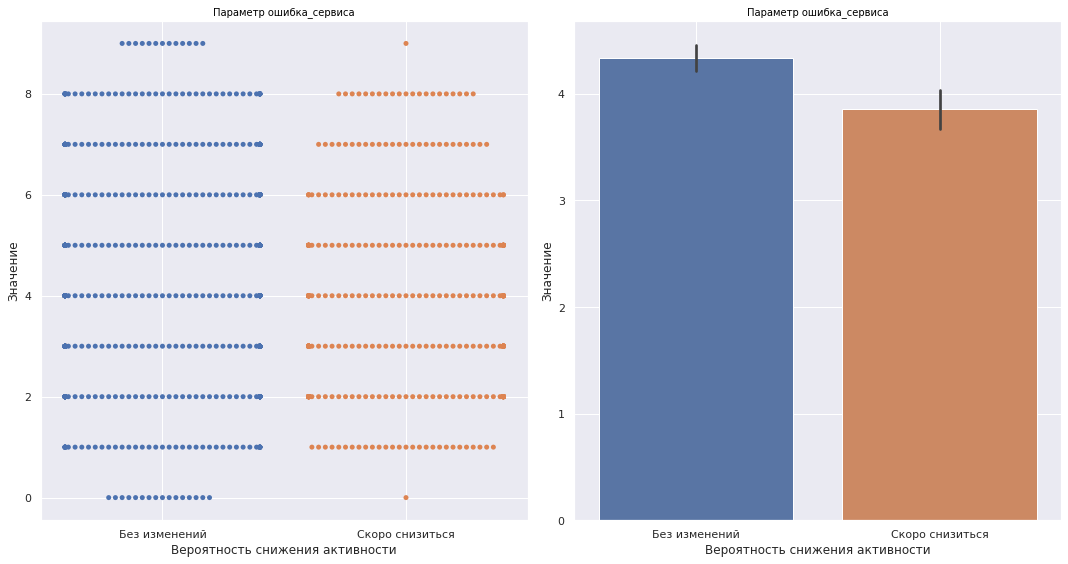

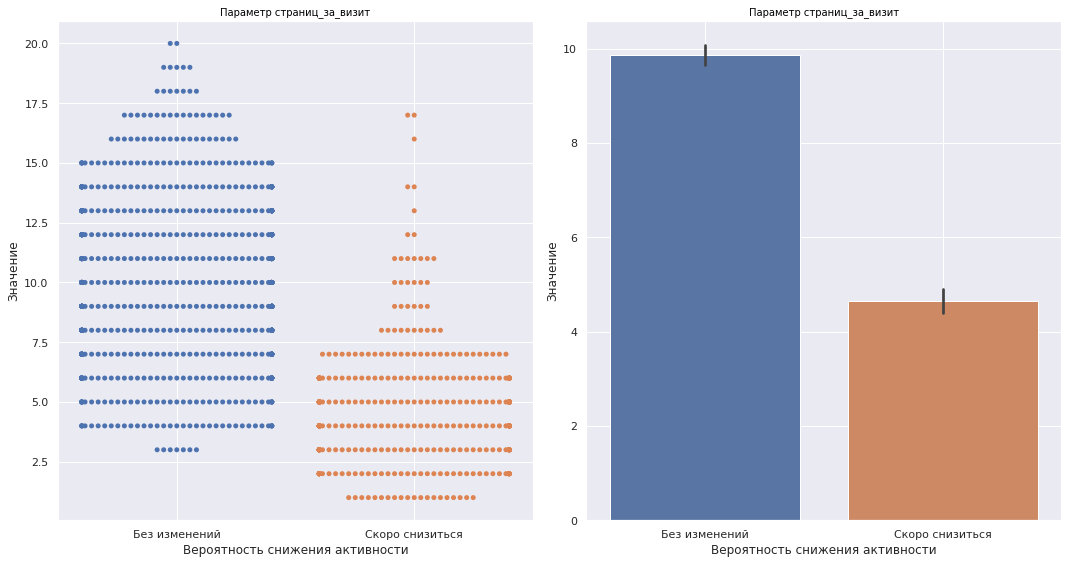

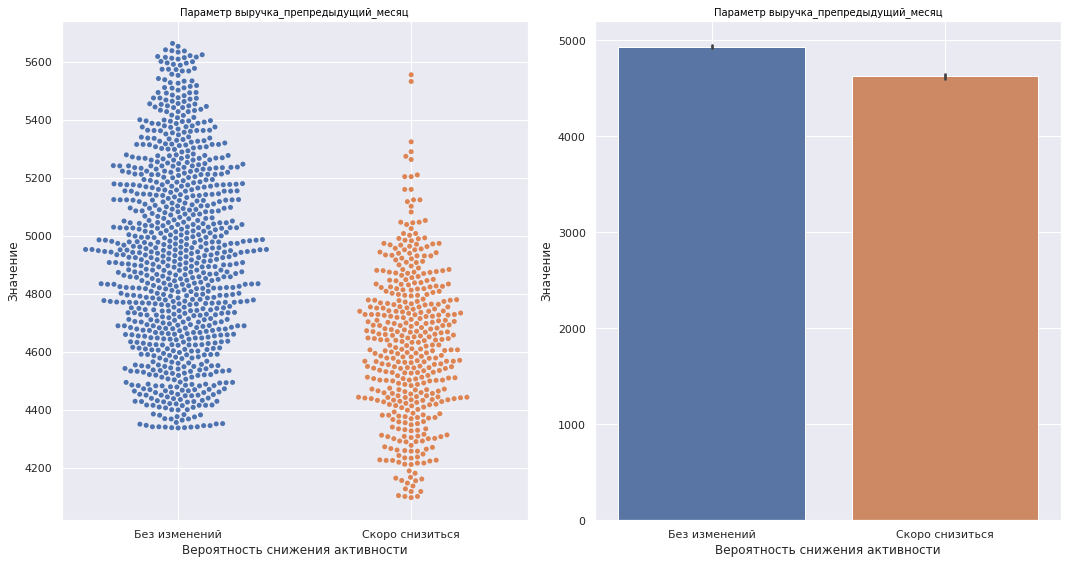

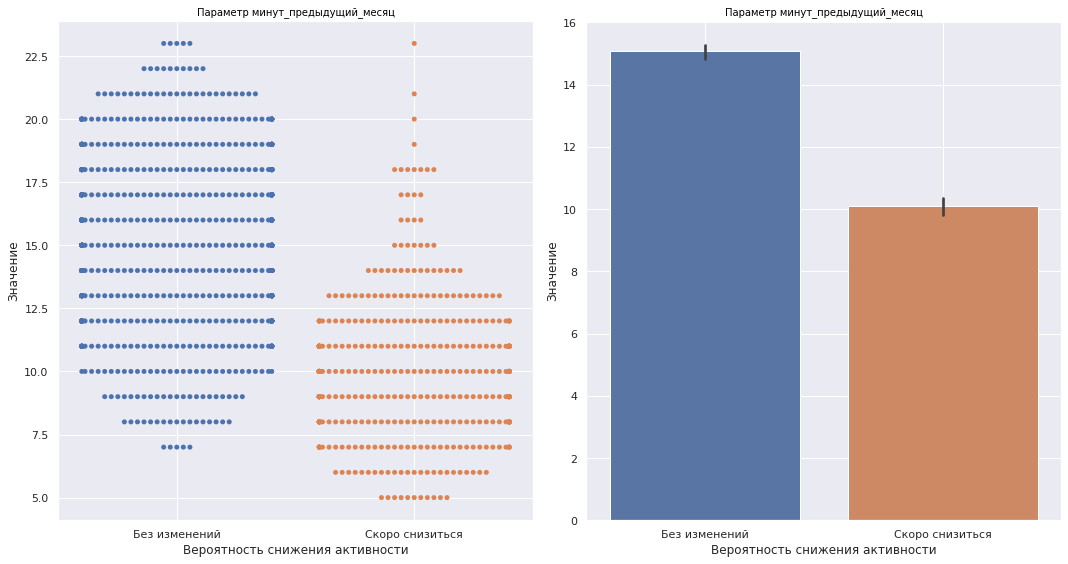

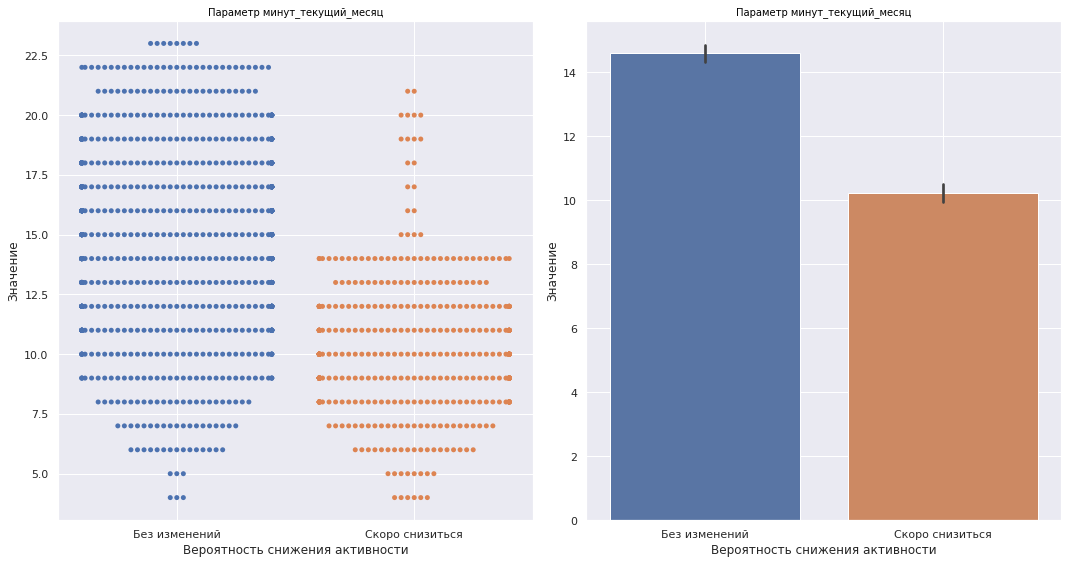

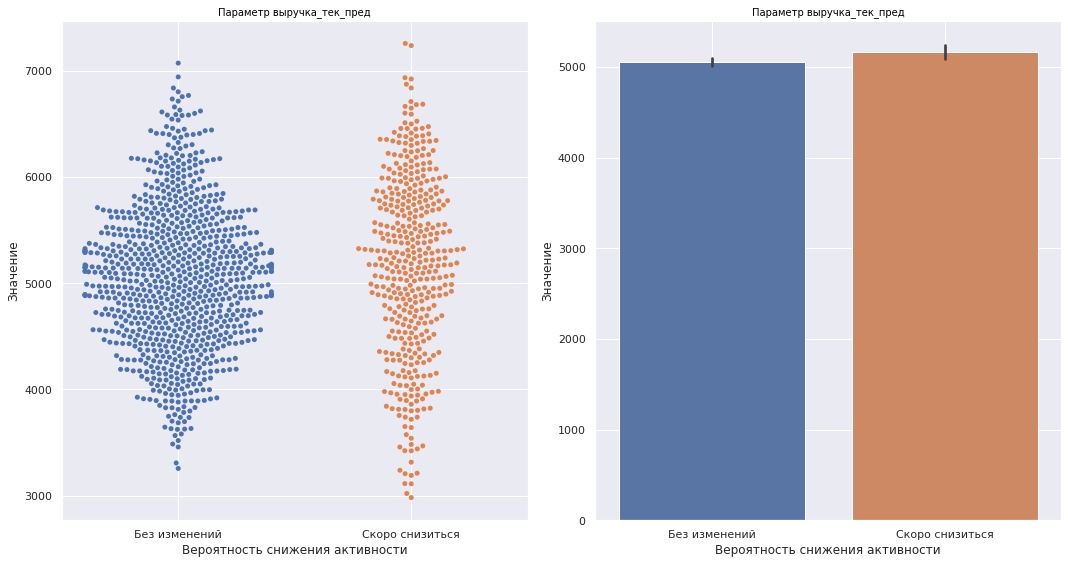

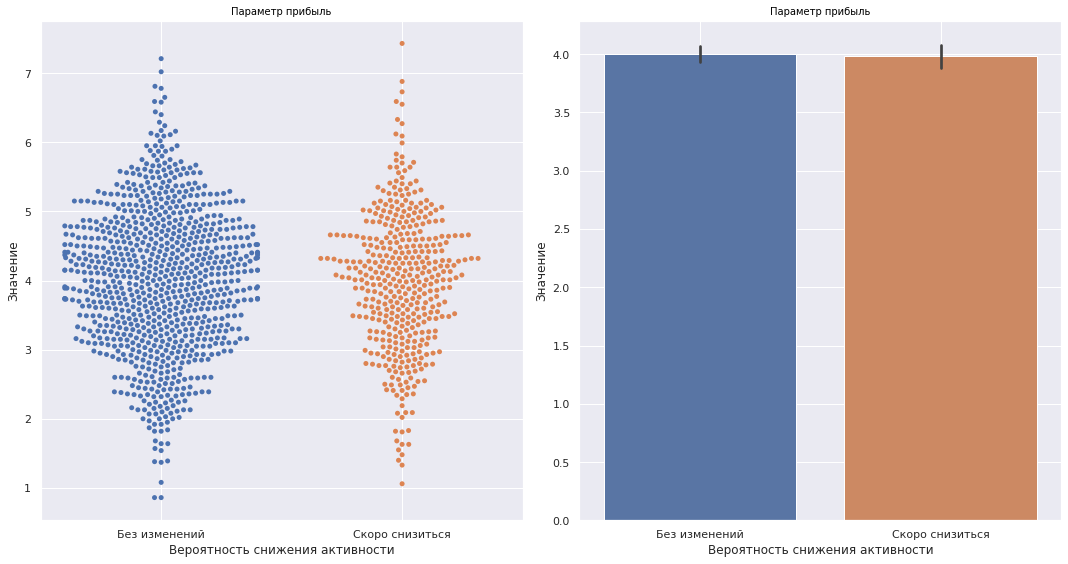

In [106]:
def graph_distribution_reactivity(df, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    sns.swarmplot(x=df['предсказание_снижении_активности'], y=df[y], data=df, ax=axes[0])
    
    axes[0].set_title(f'Параметр {y}', fontsize=10, fontweight="normal", color='black')
    axes[0].set_xlabel('Вероятность снижения активности')
    axes[0].set_ylabel('Значение')
    axes[0].grid(True)
    
    sns.barplot(x=df['предсказание_снижении_активности'], y=df[y], data=df, ax=axes[1])
    
    axes[1].set_title(f'Параметр {y}', fontsize=10, fontweight="normal", color='black')
    axes[1].set_xlabel('Вероятность снижения активности')
    axes[1].set_ylabel('Значение')
    axes[1].grid(True)

    
    plt.tight_layout()
    plt.show()


for y in box:
    graph_distribution_reactivity(df=df_market_money, y=y)

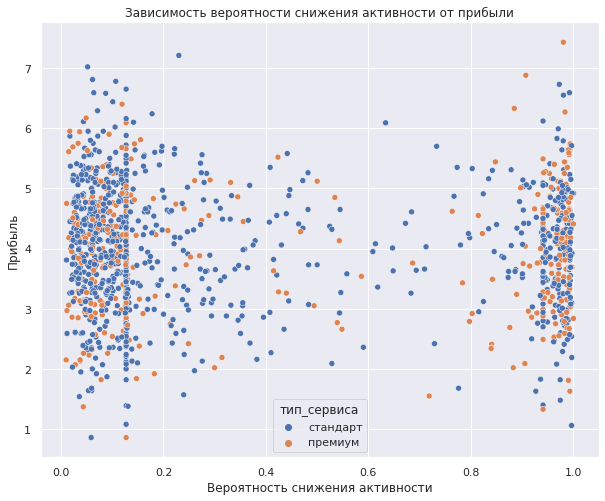

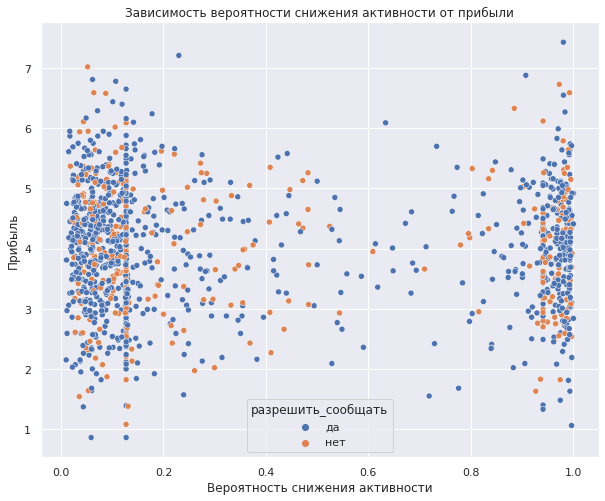

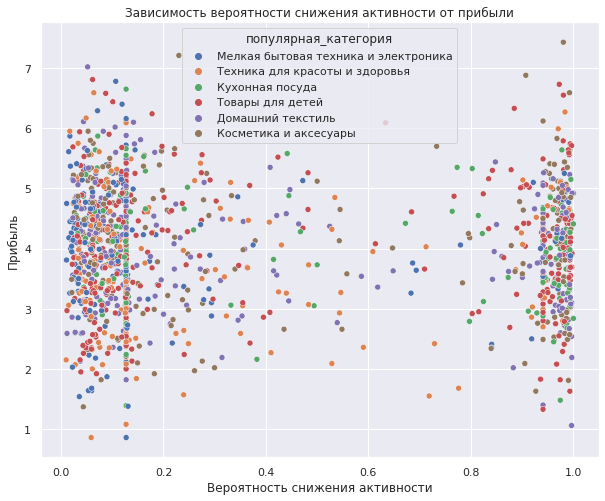

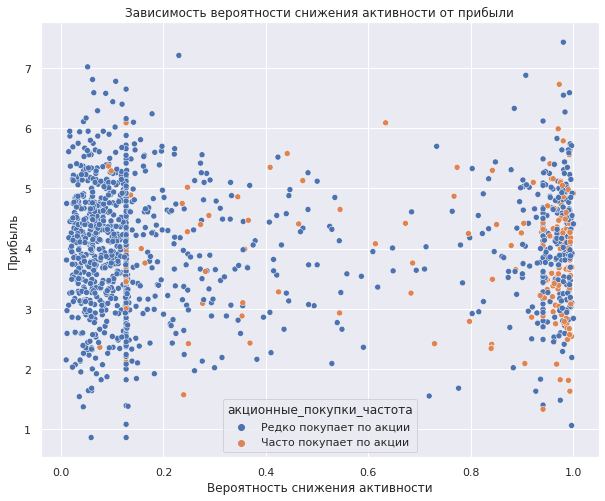

In [107]:
def graf_scatterplots(df, hue):
    fig = plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, y=df['прибыль'], x=df['вероятность_снижение_активности'], hue=hue)
    plt.xlabel('Вероятность снижения активности')
    plt.ylabel('Прибыль')
    plt.title('Зависимость вероятности снижения активности от прибыли')
    
    plt.grid(True)
    plt.show()

box = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория', 'акционные_покупки_частота']
        
for hue in box:
    graf_scatterplots(df=df_market_money, hue=hue)

На основании представленных графиков можно установить пороговые значения признаков для классификации покупателей. В частности, покупатели с низкой активностью обладают следующими характеристиками:

- маркет_актив_6_мес значение меньше 3.
- маркет_актив_тек_мес больше не замеченно.
- длительность не замечено.
- акционные_покупки выше 0,35;
- средний_просмотр_категорий_за_визит не выявленно.
- неоплаченные_продукты_штук_квартал выше 6.
- ошибка_сервиса не выявленно.
- страниц_за_визит ниже 6.
- выручка_препредыдущий_месяц ниже 5000.
- минут_предыдущий_месяц ниже 12,5.
- минут_текущий_месяц ниже 15.
- выручка_тек_пред не выявленно.

Также я провел еще дополнительный анализ. Те у кого вероятность останется без изменений использования сервиса, реже обращают внимание на акционные продажи, акционные продажи не приносят основной доход, люди которые имеют вероятность остатьтся и уйти имеют одинаковыую дохнодность, за акциями в основном приходят временные пользователи. Получается, чтобы не выжимать последнии деньги из постоянных пользователей я предлагаю, сконцентрировать внимание на удержании людей.

In [ ]:
df = df_market_money.query('вероятность_снижение_активности >= 0.6')
df = df.query('прибыль >= 4')
df = df.query('выручка_тек_пред >= 5100')

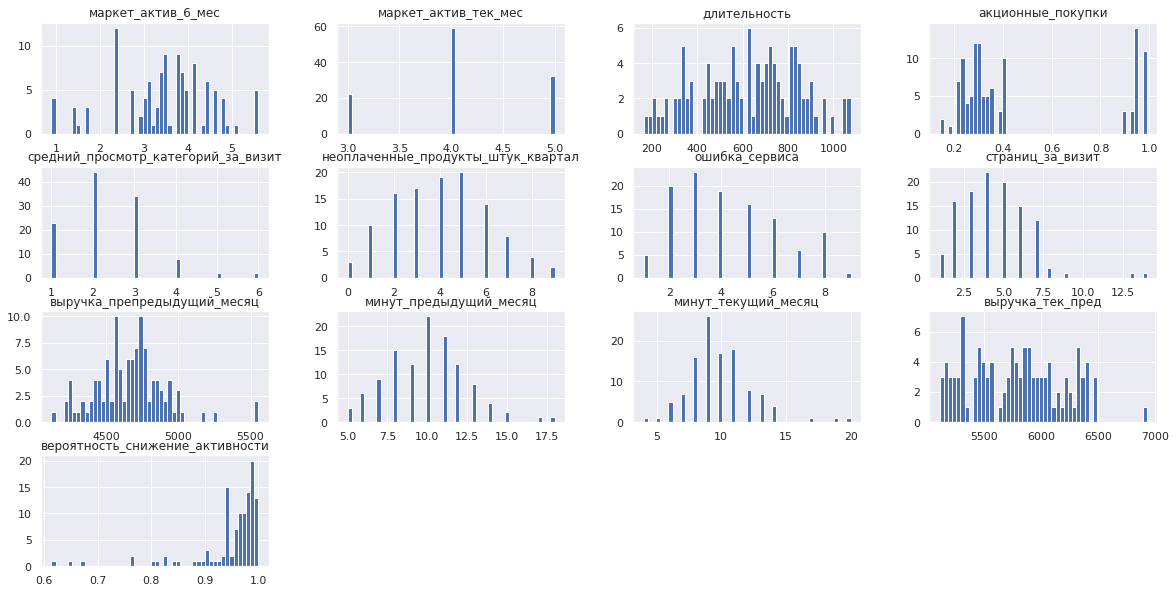

In [109]:
box = df[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц', 'выручка_тек_пред', 'вероятность_снижение_активности']]

box.hist(figsize = (20, 10), bins=50);

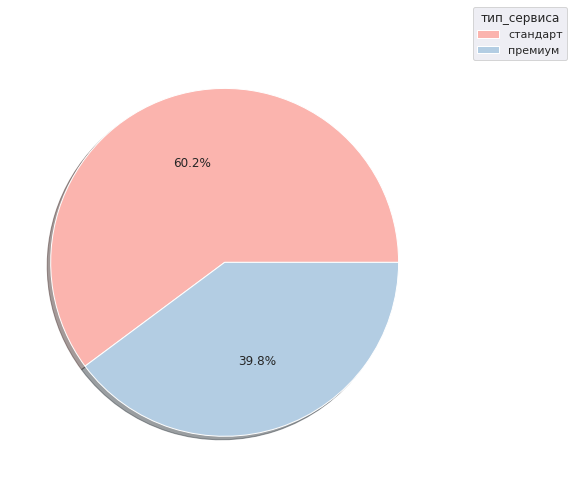

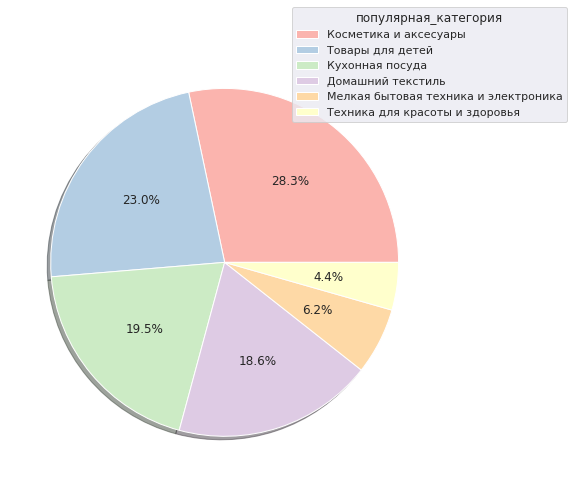

In [110]:
box = df[['тип_сервиса', 
            'популярная_категория']]

def graf_pie(df, lis):
    box = df[lis].value_counts()

    plt.figure(figsize=(10, 8))
    colors = sns.color_palette('Pastel1', len(box))
    plt.pie(x=box, autopct='%1.1f%%', shadow=True, colors=colors)

    plt.legend(box.index, title=lis, loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show();
    

for name in box:
    graf_pie(df=box, lis=name)

In [111]:
def graf_money(df, hue, x, word, x_label, y_label):
    sns.set_style('white')

    plt.figure(figsize=(20, 10))
    sns.barplot(data=df, hue=hue, x='популярная_категория', y=x)

    plt.title(f'Покупательская активность в зависимости от {word}', fontsize=16, fontweight="normal", color='black')
    plt.xlabel(f'{x_label}', fontsize=16, fontweight="normal", color='black')
    plt.ylabel(f'{y_label}', fontsize=16, fontweight="normal", color='black')

    plt.grid(color='black', linewidth=1, alpha=0.3)
    plt.show()


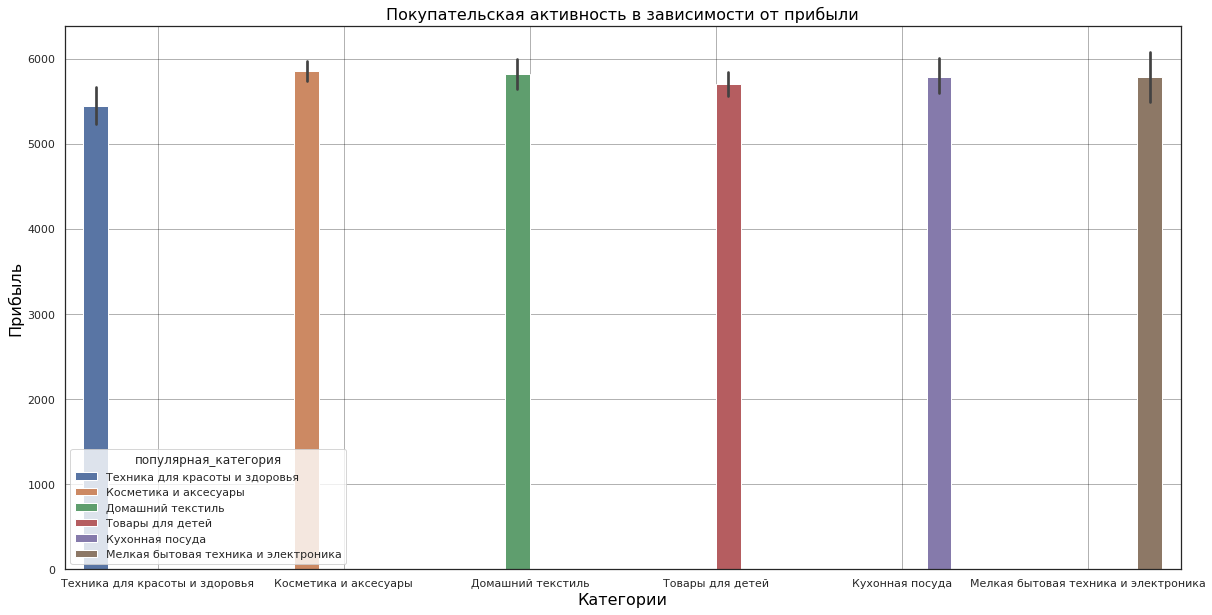

In [112]:
graf_money(df=df, hue='популярная_категория', x='выручка_тек_пред', word='прибыли', x_label='Категории', y_label='Прибыль')

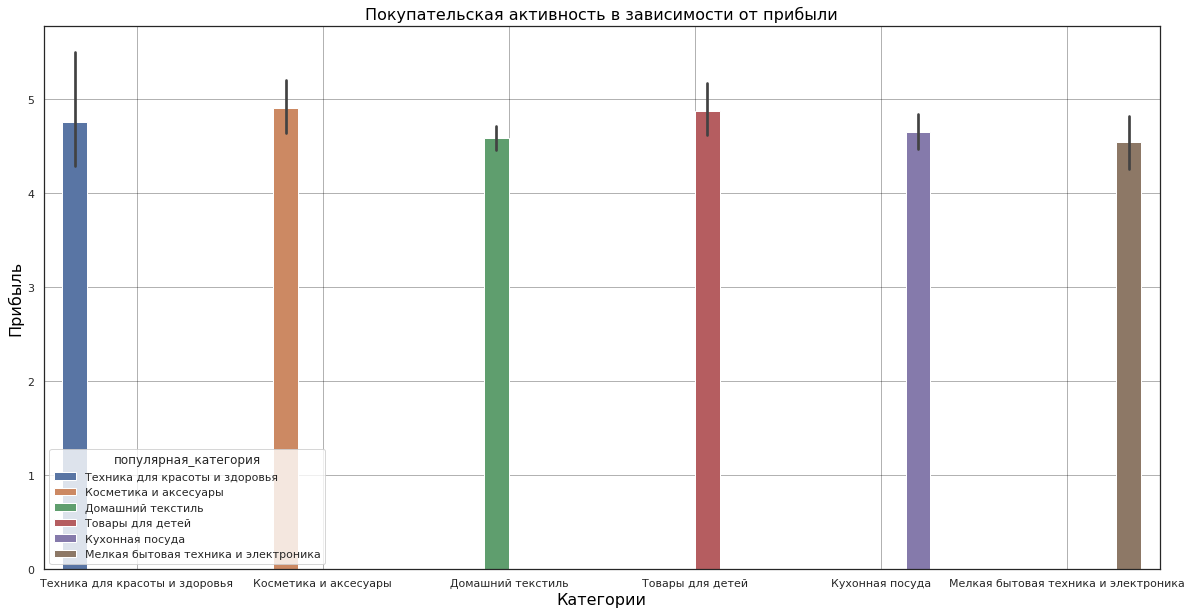

In [113]:
graf_money(df=df, hue='популярная_категория', x='прибыль', word='прибыли', x_label='Категории', y_label='Прибыль')

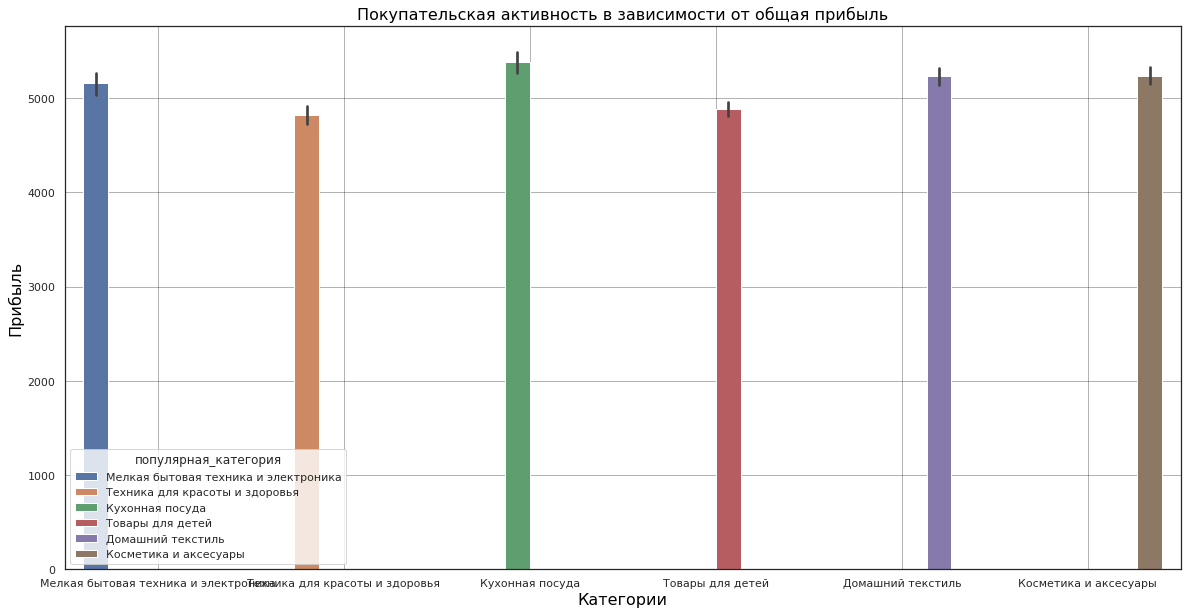

In [114]:
graf_money(df=df_market_money, hue='популярная_категория', x='выручка_тек_пред', word='общая прибыль', x_label='Категории', y_label='Прибыль')

Мы проанализировали сегмент пользователей, которые имеют высокий показатель прекратить пользоваться сайтом и имеют высокую доходность.

Эти пользователи проводят на сайте минимальное время: они мало посещают страниц, приходят только из-за скидок, мало тратят время на просмотр товара.

Я предлагаю сконцентрировать наше внимание на удержание клиента, поскольку мы те кто остаются и уходят имеют одинаковую доходность для сайта.

Чтобы стимулировать этот сегмент покупать больше и увеличить их вклад в прибыль, можно предпринять следующие шаги:

- Отказаться от рассылок. Пользователи, которые не проявляют интереса к детальному изучению товаров, вряд ли будут обращать внимание на рекламные материалы.

- Оптимизировать сайт, чтобы было меньше ошибок и было желание больше проводить время на сайте.

- Обьявлять скидки только на главной страницы сайта, чтобы пользователям пришлось бы заходить на сайт.

- Сделать упор на категории Техника для красоты и здоровья и Косметика и аксесуары, поскольку они имеют высокую доходность, у тех, кто имеет высокую вероятность прекратить пользоваться с сайтом.

## Вывод

Общий вывод:

Задача:

Состоит в разработке решения, которое предоставит персонализированные предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Исходные данные и проведённую предобработку:

- Название столбцов приведены к нижнему регистру.
- Не было найдено пропусков.
- Ошибку 'предыдцщий_месяц' была исправлена.
- Дубликатов я не нашел.

Поиск лучшей модели:

С использованием пайплайнов из библиотеки sklearn были обучены модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). В процессе обучения для каждой модели проводился подбор гиперпараметров с помощью перебора их возможных значений. Это позволило найти оптимальную конфигурацию модели, обеспечивающую наилучший результат.

На текущем этапе исследования была создана и обучена модель для выявления снижения активности покупателей сервиса. Наилучшие результаты продемонстрировала модель SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler().

Метрика ROC AUC для тестовой выборки составила 0.909, а для обучающей 0.9117. Я выбрал ROC AUC поскольку она устойчива к выбросам и подходит как для recall и precission. Я использовал метрику ROC AUC из-за ее устойчивости к дисбалансу, лучше подходит для сравнении моделей Эти результаты очень хорошие, и наша модель эффективно справляется с задачей предсказания.

Также я провел еще дополнительный анализ. Те у кого вероятность останется без изменений использования сервиса, реже обращают внимание на акционные продажи, акционные продажи не приносят основной доход, люди которые имеют вероятность остатьтся и уйти имеют одинаковыую дохнодность, за акциями в основном приходят временные пользователи. Получается, чтобы не выжимать последнии деньги из постоянных пользователей я предлагаю, сконцентрировать внимание на удержании людей.

Чтобы стимулировать этот сегмент покупать больше и увеличить их вклад в прибыль, можно предпринять следующие шаги:

- Отказаться от рассылок. Пользователи, которые не проявляют интереса к детальному изучению товаров, вряд ли будут обращать внимание на рекламные материалы.

- Оптимизировать сайт, чтобы было меньше ошибок и было желание больше проводить время на сайте.

- Обьявлять скидки только на главной страницы сайта, чтобы пользователям пришлось бы заходить на сайт.

- Сделать упор на категории Техника для красоты и здоровья и Косметика и аксесуары, поскольку они имеют высокую доходность, у тех, кто имеет высокую вероятность прекратить пользоваться с сайтом.
